<a href="https://colab.research.google.com/github/emkcosta/KillifishAtlas/blob/main/06_AgingClocks/BayesAge2_validation_ALDR_250121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Title: BayesAge2_validation_ALDR_250115_codecheck.ipynb
# Author: Lajoyce Mboning
# Edited/reviewed by: Emma K. Costa, Nimrod Rappoport
# Date:2024
# Related publication: Emma K. Costa, and Jingxun Chen, In prep.


# Description - run BayesAge 2 on the ALDR query dataset

# Set-Up

In [ ]:
import os
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from numpy import arange
from numpy import absolute
from numpy import mean
from numpy import std
import numpy as np
from scipy import stats
from sklearn.metrics import mean_absolute_error as mae
import statsmodels.api as sm
from scipy.stats import spearmanr
lowess = sm.nonparametric.lowess
from scipy.stats import poisson
from scipy.stats import pearsonr
from datetime import datetime
import time
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/My Drive/african_killifish_atlas/Code_check")

In [ ]:
palette = sns.color_palette("deep")
hex_codes = palette.as_hex()

print(hex_codes)

['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']


### Define Functions

In [ ]:
def transcriptome_reference(training_matrix,
                        reference_name,
                        output_path="./predictions/",
                        age_prediction="list",
                        age_list=[],
                        min_age=-20,
                        max_age=100,
                        age_step=1,
                        tau=0.7,
                        ):

    start_time = time.time()

    training_cv_df = pd.read_csv(training_matrix, sep="\t", index_col=0, low_memory=False)

    training_df_frequency = training_cv_df.iloc[:,:-1]

    #print(training_df_frequency)

    training_df_frequency = training_df_frequency.div(training_df_frequency.sum(axis=1), axis=0)

    genes = training_cv_df.iloc[:,:-1].columns.tolist()

    age_steps = np.arange(min_age, max_age + age_step, age_step)

    # Age values from the reference data
    age_training = training_cv_df["age"].values.flatten()

    final_training_matrix = []

    if age_prediction == "list":

        for gene in genes:
            # Frequency level of current gene
            gene_frequency = training_df_frequency[gene].values.flatten()

            # Perform lowess smoothing
            predicted_frequency_levels = lowess(gene_frequency, age_training, xvals=age_list, frac=tau)

            # Calculate Spearman rank correlation
            rho, p = spearmanr(age_training, gene_frequency)

            spearman_rank = rho

            p_value = p

            final_gene_frequency_tuple = (gene, ) + tuple(predicted_frequency_levels) + (spearman_rank, p_value)

            final_training_matrix.append(final_gene_frequency_tuple)

        df_columns = ["Gene"] + [str(num) for num in age_list] + ["spearman_rank", "p_value"]

    elif age_prediction == "steps":

        for gene in genes:
            # Frequency level of current gene
            gene_frequency = training_df_frequency[gene].values.flatten()

            # Perform lowess smoothing
            predicted_frequency_levels = lowess(gene_frequency, age_training, xvals=age_steps, frac=tau)

            # Calculate Spearman rank correlation
            rho, p = spearmanr(age_training, gene_frequency)

            spearman_rank = rho

            p_value = p

            final_gene_frequency_tuple = (gene, ) + tuple(predicted_frequency_levels) + (spearman_rank, p_value)

            final_training_matrix.append(final_gene_frequency_tuple)

        df_columns = ["Gene"] + [str(num) for num in age_steps] + ["spearman_rank", "p_value"]


    df = pd.DataFrame(final_training_matrix, columns=df_columns)
    df.set_index("Gene", inplace=True)

    # Create output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)

    # Save the DataFrame to a TSV file
    df.to_csv(os.path.join(output_path, reference_name), sep="\t")
    print(f"\nReference model dataset written to '{os.path.join(output_path, reference_name)}'")

    number_of_samples = training_cv_df.shape[0]

    # Write report file detailing input matrix
    report_file_path = os.path.join(output_path, f'{reference_name}.report.txt')
    with open(report_file_path, 'w') as writer:
        writer.write("BayesAge reference report for %s\n" % reference_name)
        now = datetime.now()
        write_datetime = now.strftime("%m/%d/%Y %H:%M:%S")
        writer.write("Reference file created: %s\n\n" % write_datetime)
        writer.write("Number of input samples = %s\n" % number_of_samples)
        writer.write("Number of input Genes = %s\n" % len(genes))
        if age_prediction == "list":
            writer.write("Predictions made for ages: %s\n" % age_list)
        elif age_prediction == "steps":
            writer.write("Predictions made for age steps from %s to %s with step %s\n" % (min_age, max_age, age_step))

    print(f"Report file generated at '{report_file_path}'")
    print("-----------------------------------------------------\n\n")

    end_time = time.time()
    elapsed_time = end_time - start_time
    print("\nTime to run construct reference: %0.3f seconds" % elapsed_time)
    print("\nThe reference is constructed and saved!")

    return df  # Optionally return the DataFrame

In [ ]:
# load normalized data
df_norm = pd.read_csv("./AtlasFiles_forLajoyce_240507/CountsNormDESeq2_AllTissue_240506.csv")

In [ ]:
# load raw data
df_unnorm = pd.read_csv("./AtlasFiles_forLajoyce_240507/Counts_Atlas_allbatches_merged_v3.csv")

In [ ]:
df_unnorm.rename(columns={"Unnamed: 0": "Gene"}, inplace=True)

df_unnorm.head(5)

,Gene,A1_1,A1_2,A10_1,A10_2,A11_1,A11_2,A12_1,A12_2,A13_1,...,P4_2,P5_1,P5_2,P6_1,P6_2,P7_1,P7_2,P8_2,P9_1,P9_2
0,a1cf,21686,52,5891,6,7544,18,10043,9,0,...,12,45920,3113,9682,4020,37522,1383,36,7855,14
1,aaas,623,585,1108,720,824,1072,1004,611,192,...,484,310,143,336,487,178,148,735,1383,717
2,aacs,1980,502,266,1913,238,2252,308,1614,56,...,1061,6587,291,3347,552,329,178,1124,382,1232
3,aadat,523,537,676,484,674,790,812,536,302,...,976,307,147,121,294,262,118,1485,781,465
4,aaed1,200,709,233,462,292,413,356,378,204,...,124,16,56,14,237,20,66,158,248,264


In [ ]:
df_unnorm.set_index("Gene", inplace=True)

In [ ]:
df_unnorm = df_unnorm.T

df_unnorm.head(5)

Gene,a1cf,aaas,aacs,aadat,aaed1,aagab,aak1,aamdc,aamp,aar2,...,zswim6,zswim7,zswim8,zufsp,zw10,zwilch,zyg11b,zyx,zzef1,zzz3
A1_1,21686,623,1980,523,200,802,1242,1224,562,577,...,829,161,1014,220,1560,42,515,3018,1422,325
A1_2,52,585,502,537,709,674,1385,2329,652,646,...,1113,92,963,153,1118,27,966,3871,275,364
A10_1,5891,1108,266,676,233,835,1374,809,716,778,...,635,156,1650,137,1370,380,662,3191,498,477
A10_2,6,720,1913,484,462,710,1745,747,1132,785,...,1918,209,1277,278,2082,44,2019,1827,251,380
A11_1,7544,824,238,674,292,726,1363,1049,795,767,...,452,206,1214,117,1139,428,560,2096,387,479


In [ ]:
df_norm = df_norm.T

In [ ]:
# load metadata
df_metadata = pd.read_csv("./AtlasFiles_forLajoyce_240507/ExperimentDesign_allbatches_combined_v7.csv")

df_metadata.head(3)

/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,Unnamed: 0,animalID,sex,cohort,age_days,harvest_date,hatch_date,tissue,tissue_grind_date,RNA_extract_date,RNA_batch,RNA_extractor,RNAID,cDNA_batch,plate_well,sampleNames,lib,censored,censor_code,notes
0,A1_1,J9,F,2,155,8/16/22,3/14/22,Gut,NaN,3/8/23,Gut_1,EC,RNA352,1,A1,A1,A1_1,NaN,NaN,NaN
1,A1_2,A01,M,2,78,5/31/22,3/14/22,Bone,4/19/23,4/22/23,Bone_1,EC,RNA572,2,A1,A1,A1_2,NaN,NaN,NaN
2,A10_1,P_1B_10,M,1B,133,1/31/22,9/20/21,Kidney,NaN,3/4/23,Kidney_1,JC,R258,1,A10,A10,A10_1,NaN,NaN,NaN


In [ ]:
df_metadata.reset_index()

,index,Unnamed: 0,animalID,sex,cohort,age_days,harvest_date,hatch_date,tissue,tissue_grind_date,...,RNA_batch,RNA_extractor,RNAID,cDNA_batch,plate_well,sampleNames,lib,censored,censor_code,notes
0,0,A1_1,J9,F,2,155,8/16/22,3/14/22,Gut,NaN,...,Gut_1,EC,RNA352,1,A1,A1,A1_1,NaN,NaN,NaN
1,1,A1_2,A01,M,2,78,5/31/22,3/14/22,Bone,4/19/23,...,Bone_1,EC,RNA572,2,A1,A1,A1_2,NaN,NaN,NaN
2,2,A10_1,P_1B_10,M,1B,133,1/31/22,9/20/21,Kidney,NaN,...,Kidney_1,JC,R258,1,A10,A10,A10_1,NaN,NaN,NaN
3,3,A10_2,J_1A_14,M,1A,75,11/22/21,9/8/21,SpinalCord,NaN,...,SpinalCord_1,EC,RNA423,2,A10,A10,A10_2,NaN,NaN,NaN
4,4,A11_1,J_1A_22,M,1A,47,10/25/21,9/8/21,Kidney,NaN,...,Kidney_2,JC,R274,1,A11,A11,A11_1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672,672,P7_1,J_1A_25,M,1A,103,12/20/21,9/8/21,Liver,NaN,...,Liver_1,IG,RNA689,1,P7,P7,P7_1,NaN,NaN,NaN
673,673,P7_2,P_1B_1,F,1B,77,12/6/21,9/20/21,Fat,4/13/23,...,Fat_3,EC,RNA566,2,P7,P7,P7_2,NaN,NaN,NaN
674,674,P8_2,J_1A_25,M,1A,103,12/20/21,9/8/21,Eye,NaN,...,Eye_1,MRW,642,2,P8,P8,P8_2,NaN,NaN,NaN
675,675,P9_1,J_1B_2,M,1B,49,11/8/21,9/20/21,Kidney,NaN,...,Kidney_1,JC,R257,1,P9,P9,P9_1,NaN,NaN,NaN


In [ ]:
df_metadata.rename(columns={"Unnamed: 0": "sample"}, inplace=True)

df_metadata.head(3)

/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,sample,animalID,sex,cohort,age_days,harvest_date,hatch_date,tissue,tissue_grind_date,RNA_extract_date,RNA_batch,RNA_extractor,RNAID,cDNA_batch,plate_well,sampleNames,lib,censored,censor_code,notes
0,A1_1,J9,F,2,155,8/16/22,3/14/22,Gut,NaN,3/8/23,Gut_1,EC,RNA352,1,A1,A1,A1_1,NaN,NaN,NaN
1,A1_2,A01,M,2,78,5/31/22,3/14/22,Bone,4/19/23,4/22/23,Bone_1,EC,RNA572,2,A1,A1,A1_2,NaN,NaN,NaN
2,A10_1,P_1B_10,M,1B,133,1/31/22,9/20/21,Kidney,NaN,3/4/23,Kidney_1,JC,R258,1,A10,A10,A10_1,NaN,NaN,NaN


In [ ]:
df_metadata.set_index("sample", inplace=True)

In [ ]:
# Merge based on index
combined_df = pd.concat([df_norm, df_metadata[['sex', 'tissue', 'age_days']]], axis=1)

In [ ]:
combined_df["tissue"].value_counts()

,count
tissue,
Gut,55
Kidney,55
Muscle,55
Spleen,55
SpinalCord,54
Heart,54
Skin,54
Brain,54
Liver,54


In [ ]:
combined_df_counts = pd.concat([df_unnorm, df_metadata[["sex", "tissue", "age_days"]]], axis=1)

combined_df_counts.head(5)

,a1cf,aaas,aacs,aadat,aaed1,aagab,aak1,aamdc,aamp,aar2,...,zufsp,zw10,zwilch,zyg11b,zyx,zzef1,zzz3,sex,tissue,age_days
A1_1,21686,623,1980,523,200,802,1242,1224,562,577,...,220,1560,42,515,3018,1422,325,F,Gut,155
A1_2,52,585,502,537,709,674,1385,2329,652,646,...,153,1118,27,966,3871,275,364,M,Bone,78
A10_1,5891,1108,266,676,233,835,1374,809,716,778,...,137,1370,380,662,3191,498,477,M,Kidney,133
A10_2,6,720,1913,484,462,710,1745,747,1132,785,...,278,2082,44,2019,1827,251,380,M,SpinalCord,75
A11_1,7544,824,238,674,292,726,1363,1049,795,767,...,117,1139,428,560,2096,387,479,M,Kidney,47


In [ ]:
combined_df["tissue"].value_counts()

,count
tissue,
Gut,55
Kidney,55
Muscle,55
Spleen,55
SpinalCord,54
Heart,54
Skin,54
Brain,54
Liver,54


# Liver - Prepare Ref for Use with Query datasets

### Subset Male Samples

In [ ]:
liver_df = combined_df.loc[combined_df.iloc[:,-2] == "Liver"]

In [ ]:
liver_df_male = liver_df.loc[liver_df.iloc[:,-3] == "M"]

In [ ]:
liver_df_male["age_days"].value_counts()

,count
age_days,
133,4
162,4
134,2
152,2
102,2
147,2
52,2
161,2
78,2


In [ ]:
liver_df_male.head(5)

,a1cf,aaas,aacs,aadat,aaed1,aagab,aak1,aamdc,aamp,aar2,...,zufsp,zw10,zwilch,zyg11b,zyx,zzef1,zzz3,sex,tissue,age_days
A5_1,100443.541866,569.498293,9197.259866,817.106246,41.267992,1034.451005,982.178215,4385.411973,935.407824,558.493495,...,101.794381,1141.747785,2.751199,511.723104,2555.864318,299.880743,448.445515,M,Liver,134
A8_1,139272.752006,589.285647,3047.097867,1149.107012,76.116063,1023.883812,1092.633804,2536.383640,989.508816,643.303498,...,130.133914,1156.473083,22.098212,564.732079,2492.187216,378.124957,414.955310,M,Liver,133
B7_1,106880.160432,442.985714,13625.869465,670.276813,71.898205,1080.792369,1289.529093,2620.805531,772.325878,712.024158,...,34.789454,1338.234329,6.957891,547.354076,2435.261777,582.143529,565.908451,M,Liver,133
C5_1,113772.810228,696.735509,24082.457958,633.892699,62.842811,1158.493553,920.783791,3191.321862,857.940980,740.452247,...,166.670063,1155.761257,24.590665,478.151820,2330.648586,237.709762,437.167378,M,Liver,162
C7_1,109847.738206,626.472460,8772.952023,818.154332,91.165768,1302.034180,1491.378468,2718.609966,885.944262,883.606679,...,179.993953,766.727488,16.363087,523.618773,2966.393850,367.000658,446.478507,M,Liver,152


In [ ]:
age_days_value_counts = liver_df_male["age_days"].value_counts().index.tolist()

print(sorted(age_days_value_counts))

[47, 49, 52, 75, 77, 78, 102, 103, 133, 134, 147, 152, 161, 162]


In [ ]:
liver_gene_expression_data_male = liver_df_male.iloc[:, :-3]

In [ ]:
liver_df_male_age = liver_gene_expression_data_male.copy()

liver_df_male_age.head(3)

,a1cf,aaas,aacs,aadat,aaed1,aagab,aak1,aamdc,aamp,aar2,...,zswim6,zswim7,zswim8,zufsp,zw10,zwilch,zyg11b,zyx,zzef1,zzz3
A5_1,100443.541866,569.498293,9197.259866,817.106246,41.267992,1034.451005,982.178215,4385.411973,935.407824,558.493495,...,228.349557,71.531187,723.565464,101.794381,1141.747785,2.751199,511.723104,2555.864318,299.880743,448.445515
A8_1,139272.752006,589.285647,3047.097867,1149.107012,76.116063,1023.883812,1092.633804,2536.383640,989.508816,643.303498,...,184.151765,56.473208,785.714196,130.133914,1156.473083,22.098212,564.732079,2492.187216,378.124957,414.955310
B7_1,106880.160432,442.985714,13625.869465,670.276813,71.898205,1080.792369,1289.529093,2620.805531,772.325878,712.024158,...,306.147195,104.368362,1386.939564,34.789454,1338.234329,6.957891,547.354076,2435.261777,582.143529,565.908451


In [ ]:
liver_df_male_age["age"] = liver_df_male["age_days"].tolist()

liver_df_male_age.head(3)

,a1cf,aaas,aacs,aadat,aaed1,aagab,aak1,aamdc,aamp,aar2,...,zswim7,zswim8,zufsp,zw10,zwilch,zyg11b,zyx,zzef1,zzz3,age
A5_1,100443.541866,569.498293,9197.259866,817.106246,41.267992,1034.451005,982.178215,4385.411973,935.407824,558.493495,...,71.531187,723.565464,101.794381,1141.747785,2.751199,511.723104,2555.864318,299.880743,448.445515,134
A8_1,139272.752006,589.285647,3047.097867,1149.107012,76.116063,1023.883812,1092.633804,2536.383640,989.508816,643.303498,...,56.473208,785.714196,130.133914,1156.473083,22.098212,564.732079,2492.187216,378.124957,414.955310,133
B7_1,106880.160432,442.985714,13625.869465,670.276813,71.898205,1080.792369,1289.529093,2620.805531,772.325878,712.024158,...,104.368362,1386.939564,34.789454,1338.234329,6.957891,547.354076,2435.261777,582.143529,565.908451,133


In [ ]:
male_age_steps = list(np.arange(47, 163, 1))

#print(male_age_steps)

### Transcriptome Reference

In [ ]:
transcriptome_reference(training_matrix= "/content/drive/My Drive/african_killifish_atlas/Code_check/inputs/killifish_liver_male.csv",
                            reference_name="killifish_liver_reference_male",
                            output_path="/content/drive/My Drive/african_killifish_atlas/Code_check/references/",
                            age_prediction="list",
                            age_list=male_age_steps,
                            min_age=1,
                            max_age=24,
                            age_step=1,
                            tau=0.7)


Reference model dataset written to '/content/drive/My Drive/african_killifish_atlas/Code_check/references/killifish_liver_reference_male'
Report file generated at '/content/drive/My Drive/african_killifish_atlas/Code_check/references/killifish_liver_reference_male.report.txt'
-----------------------------------------------------



Time to run construct reference: 144.839 seconds

The reference is constructed and saved!


,47,48,49,50,51,52,53,54,55,56,...,155,156,157,158,159,160,161,162,spearman_rank,p_value
Gene,,,,,,,,,,,,,,,,,,,,,
a1cf,1.200495e-03,1.204315e-03,1.208144e-03,1.211982e-03,1.215826e-03,1.219677e-03,1.223532e-03,1.227391e-03,1.231255e-03,1.235122e-03,...,1.501719e-03,1.501826e-03,1.501903e-03,1.501950e-03,1.501964e-03,1.501945e-03,1.501892e-03,1.501803e-03,0.350897,0.052933
aaas,1.014194e-05,1.008828e-05,1.003478e-05,9.981418e-06,9.928163e-06,9.874978e-06,9.821834e-06,9.768724e-06,9.715646e-06,9.662600e-06,...,8.577768e-06,8.617215e-06,8.657006e-06,8.697112e-06,8.737509e-06,8.778170e-06,8.819071e-06,8.860190e-06,-0.080696,0.666077
aacs,2.028433e-04,1.988176e-04,1.948155e-04,1.908390e-04,1.868899e-04,1.829700e-04,1.790806e-04,1.752220e-04,1.713940e-04,1.675964e-04,...,1.581007e-04,1.605000e-04,1.629069e-04,1.653216e-04,1.677441e-04,1.701745e-04,1.726128e-04,1.750591e-04,0.192336,0.299926
aadat,1.226519e-05,1.221618e-05,1.216738e-05,1.211880e-05,1.207041e-05,1.202222e-05,1.197421e-05,1.192638e-05,1.187872e-05,1.183124e-05,...,9.458603e-06,9.453647e-06,9.448820e-06,9.444096e-06,9.439452e-06,9.434863e-06,9.430308e-06,9.425763e-06,-0.577008,0.000678
aaed1,1.368052e-06,1.363921e-06,1.359812e-06,1.355727e-06,1.351661e-06,1.347612e-06,1.343576e-06,1.339552e-06,1.335541e-06,1.331544e-06,...,8.972622e-07,8.986657e-07,9.001994e-07,9.018599e-07,9.036441e-07,9.055490e-07,9.075714e-07,9.097081e-07,-0.346649,0.056074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zwilch,9.910576e-07,9.751420e-07,9.593228e-07,9.436035e-07,9.279871e-07,9.124767e-07,8.970744e-07,8.817802e-07,8.665928e-07,8.515112e-07,...,1.316761e-07,1.293816e-07,1.271295e-07,1.249198e-07,1.227527e-07,1.206279e-07,1.185457e-07,1.165057e-07,-0.394582,0.028045
zyg11b,7.768768e-06,7.766835e-06,7.764657e-06,7.762231e-06,7.759549e-06,7.756599e-06,7.753371e-06,7.749866e-06,7.746087e-06,7.742037e-06,...,6.838227e-06,6.835673e-06,6.833146e-06,6.830645e-06,6.828166e-06,6.825708e-06,6.823268e-06,6.820842e-06,-0.316110,0.083195
zyx,4.549439e-05,4.540138e-05,4.530818e-05,4.521481e-05,4.512122e-05,4.502737e-05,4.493324e-05,4.483881e-05,4.474408e-05,4.464904e-05,...,3.626922e-05,3.631826e-05,3.636972e-05,3.642348e-05,3.647945e-05,3.653751e-05,3.659756e-05,3.665949e-05,-0.375166,0.037558


# Caloric Restriction Validation

### Load McKay et al - Age Prediction

In [ ]:
df_cr = pd.read_csv("./Data_from_Others/ALDR/GSE216369_Counts_ALDR_220325.csv")

In [ ]:
df_cr = df_cr.T

df_cr.head(3)

,LOC107375582,LOC107388276,LOC107382448,LOC107377727,pex1,LOC107393665,LOC107377394,zbtb41,LOC107397029,LOC107377691,...,LOC107393324,chp1,LOC107392884,LOC107372821,LOC107386901,LOC107386251,LOC107378151,dag1,LOC107396310,LOC107378249
f_AL_L_1,0,0,1,176,142,8,0,94,0,385,...,2,1369,0,771,2,559,0,20,38,77
m_AL_L_1,0,5,0,34,372,22,0,113,0,406,...,0,2628,0,759,8,485,2,18,4,20
f_AL_BR_1,4,317,0,361,576,1238,4,1134,0,194,...,7,2326,134,684,0,1534,277,1098,2062,50


In [ ]:
df_cr_age = df_cr.copy()

In [ ]:
df_cr_age["treatment"] = ''
df_cr_age["tissue"] = ''
df_cr_age.loc[df_cr_age.index.str.contains("AL"), "treatment"] = "AL"
df_cr_age.loc[df_cr_age.index.str.contains("DR"), "treatment"] = "DR"
df_cr_age.loc[df_cr_age.index.str.contains("BR"), "tissue"] = "Brain"
# Step 4: Assign "Liver" to all rows where the tissue is not "Brain"
df_cr_age.loc[df_cr_age["tissue"] != "Brain", "tissue"] = "Liver"
df_cr_age.head(5)

,LOC107375582,LOC107388276,LOC107382448,LOC107377727,pex1,LOC107393665,LOC107377394,zbtb41,LOC107397029,LOC107377691,...,LOC107392884,LOC107372821,LOC107386901,LOC107386251,LOC107378151,dag1,LOC107396310,LOC107378249,treatment,tissue
f_AL_L_1,0,0,1,176,142,8,0,94,0,385,...,0,771,2,559,0,20,38,77,AL,Liver
m_AL_L_1,0,5,0,34,372,22,0,113,0,406,...,0,759,8,485,2,18,4,20,AL,Liver
f_AL_BR_1,4,317,0,361,576,1238,4,1134,0,194,...,134,684,0,1534,277,1098,2062,50,AL,Brain
m_DR_L_1,0,0,0,16,375,44,0,88,0,294,...,0,841,8,667,4,34,28,26,DR,Liver
f_DR_BR_1,11,228,0,271,588,874,36,817,2,139,...,210,353,4,1706,133,681,1780,107,DR,Brain


In [ ]:
df_cr_age_brain = df_cr_age[df_cr_age["tissue"] == "Brain"]

df_cr_age_brain.head(10)

,LOC107375582,LOC107388276,LOC107382448,LOC107377727,pex1,LOC107393665,LOC107377394,zbtb41,LOC107397029,LOC107377691,...,LOC107392884,LOC107372821,LOC107386901,LOC107386251,LOC107378151,dag1,LOC107396310,LOC107378249,treatment,tissue
f_AL_BR_1,4,317,0,361,576,1238,4,1134,0,194,...,134,684,0,1534,277,1098,2062,50,AL,Brain
f_DR_BR_1,11,228,0,271,588,874,36,817,2,139,...,210,353,4,1706,133,681,1780,107,DR,Brain
f_AL_BR_2,4,398,0,263,894,1474,2,1852,0,171,...,286,712,0,1603,326,1465,2702,82,AL,Brain
m_AL_BR_1,6,286,0,244,478,1018,0,1423,0,66,...,154,574,0,1134,255,1009,1969,103,AL,Brain
m_DR_BR_1,15,405,1,260,594,1044,8,1558,0,89,...,294,741,2,1533,110,912,2051,148,DR,Brain
m_DR_BR_2,6,225,0,152,542,1531,40,1133,3,116,...,156,525,84,1216,331,1221,2080,54,DR,Brain
m_AL_BR_2,8,276,0,211,615,1219,4,1297,0,134,...,114,715,0,1354,200,1068,1901,102,AL,Brain
f_DR_BR_2,2,135,0,88,477,911,0,938,0,82,...,102,313,0,957,181,726,1437,70,DR,Brain
m_AL_BR_3,4,493,0,276,557,1327,2,1480,0,122,...,251,721,0,1471,304,1207,2219,52,AL,Brain
f_AL_BR_3,7,443,4,289,656,1461,0,1621,2,144,...,269,741,0,1675,279,1392,2596,208,AL,Brain


In [ ]:
df_cr_age_liver = df_cr_age[df_cr_age["tissue"] == "Liver"]

df_cr_age_liver.head(5)

,LOC107375582,LOC107388276,LOC107382448,LOC107377727,pex1,LOC107393665,LOC107377394,zbtb41,LOC107397029,LOC107377691,...,LOC107392884,LOC107372821,LOC107386901,LOC107386251,LOC107378151,dag1,LOC107396310,LOC107378249,treatment,tissue
f_AL_L_1,0,0,1,176,142,8,0,94,0,385,...,0,771,2,559,0,20,38,77,AL,Liver
m_AL_L_1,0,5,0,34,372,22,0,113,0,406,...,0,759,8,485,2,18,4,20,AL,Liver
m_DR_L_1,0,0,0,16,375,44,0,88,0,294,...,0,841,8,667,4,34,28,26,DR,Liver
f_AL_L_2,0,0,0,6,127,2,2,18,0,275,...,0,634,2,195,0,26,4,24,AL,Liver
f_DR_L_1,0,0,0,18,455,38,0,148,0,226,...,0,3009,0,458,16,16,14,15,DR,Liver


In [ ]:
df_cr_age_liver.loc[:, "sex"] = ''

df_cr_age_liver.loc[df_cr_age_liver.index.str.startswith("f"), "sex"] = "f"
df_cr_age_liver.loc[df_cr_age_liver.index.str.startswith("m"), 'sex'] = "m"

df_cr_age_liver.head(10)

,LOC107375582,LOC107388276,LOC107382448,LOC107377727,pex1,LOC107393665,LOC107377394,zbtb41,LOC107397029,LOC107377691,...,LOC107372821,LOC107386901,LOC107386251,LOC107378151,dag1,LOC107396310,LOC107378249,treatment,tissue,sex
f_AL_L_1,0,0,1,176,142,8,0,94,0,385,...,771,2,559,0,20,38,77,AL,Liver,f
m_AL_L_1,0,5,0,34,372,22,0,113,0,406,...,759,8,485,2,18,4,20,AL,Liver,m
m_DR_L_1,0,0,0,16,375,44,0,88,0,294,...,841,8,667,4,34,28,26,DR,Liver,m
f_AL_L_2,0,0,0,6,127,2,2,18,0,275,...,634,2,195,0,26,4,24,AL,Liver,f
f_DR_L_1,0,0,0,18,455,38,0,148,0,226,...,3009,0,458,16,16,14,15,DR,Liver,f
m_AL_L_2,0,0,0,26,229,10,2,119,0,302,...,803,0,479,22,18,6,61,AL,Liver,m
m_DR_L_2,2,0,0,14,491,70,22,126,0,298,...,1097,16,747,8,44,10,30,DR,Liver,m
f_DR_L_2,0,0,0,36,241,24,0,144,0,276,...,1908,6,304,8,20,4,72,DR,Liver,f
f_AL_L_3,0,0,0,33,336,8,4,112,0,211,...,1204,4,370,10,24,6,59,AL,Liver,f
m_DR_L_3,2,0,0,4,308,18,0,92,0,240,...,603,0,404,2,6,14,24,DR,Liver,m


In [ ]:
df_cr_age_liver.shape

(16, 25125)

In [ ]:
df_cr_age_liver_raw_counts = df_cr_age_liver.iloc[:,:-3]

df_cr_age_liver_raw_counts.head(5)

,LOC107375582,LOC107388276,LOC107382448,LOC107377727,pex1,LOC107393665,LOC107377394,zbtb41,LOC107397029,LOC107377691,...,LOC107393324,chp1,LOC107392884,LOC107372821,LOC107386901,LOC107386251,LOC107378151,dag1,LOC107396310,LOC107378249
f_AL_L_1,0,0,1,176,142,8,0,94,0,385,...,2,1369,0,771,2,559,0,20,38,77
m_AL_L_1,0,5,0,34,372,22,0,113,0,406,...,0,2628,0,759,8,485,2,18,4,20
m_DR_L_1,0,0,0,16,375,44,0,88,0,294,...,0,2142,0,841,8,667,4,34,28,26
f_AL_L_2,0,0,0,6,127,2,2,18,0,275,...,0,3469,0,634,2,195,0,26,4,24
f_DR_L_1,0,0,0,18,455,38,0,148,0,226,...,0,2136,0,3009,0,458,16,16,14,15


In [ ]:
df_cr_age_liver_raw_counts_female = df_cr_age_liver[df_cr_age_liver["sex"] == "f"]

df_cr_age_liver_raw_counts_female.head(5)

,LOC107375582,LOC107388276,LOC107382448,LOC107377727,pex1,LOC107393665,LOC107377394,zbtb41,LOC107397029,LOC107377691,...,LOC107372821,LOC107386901,LOC107386251,LOC107378151,dag1,LOC107396310,LOC107378249,treatment,tissue,sex
f_AL_L_1,0,0,1,176,142,8,0,94,0,385,...,771,2,559,0,20,38,77,AL,Liver,f
f_AL_L_2,0,0,0,6,127,2,2,18,0,275,...,634,2,195,0,26,4,24,AL,Liver,f
f_DR_L_1,0,0,0,18,455,38,0,148,0,226,...,3009,0,458,16,16,14,15,DR,Liver,f
f_DR_L_2,0,0,0,36,241,24,0,144,0,276,...,1908,6,304,8,20,4,72,DR,Liver,f
f_AL_L_3,0,0,0,33,336,8,4,112,0,211,...,1204,4,370,10,24,6,59,AL,Liver,f


In [ ]:
df_cr_age_liver_raw_counts_female

,LOC107375582,LOC107388276,LOC107382448,LOC107377727,pex1,LOC107393665,LOC107377394,zbtb41,LOC107397029,LOC107377691,...,LOC107372821,LOC107386901,LOC107386251,LOC107378151,dag1,LOC107396310,LOC107378249,treatment,tissue,sex
f_AL_L_1,0,0,1,176,142,8,0,94,0,385,...,771,2,559,0,20,38,77,AL,Liver,f
f_AL_L_2,0,0,0,6,127,2,2,18,0,275,...,634,2,195,0,26,4,24,AL,Liver,f
f_DR_L_1,0,0,0,18,455,38,0,148,0,226,...,3009,0,458,16,16,14,15,DR,Liver,f
f_DR_L_2,0,0,0,36,241,24,0,144,0,276,...,1908,6,304,8,20,4,72,DR,Liver,f
f_AL_L_3,0,0,0,33,336,8,4,112,0,211,...,1204,4,370,10,24,6,59,AL,Liver,f
f_AL_L_4,0,0,0,104,283,2,2,69,0,342,...,817,3,293,2,24,16,2,AL,Liver,f
f_DR_L_3,0,0,0,34,242,14,0,132,0,248,...,1765,2,222,8,20,4,57,DR,Liver,f
f_DR_L_4,0,0,0,60,267,23,2,175,0,299,...,706,4,309,6,18,6,2,DR,Liver,f


In [ ]:
df_cr_age_liver_raw_counts_freq_female = df_cr_age_liver_raw_counts_female.iloc[:,:-3]

df_cr_age_liver_raw_counts_freq_female = df_cr_age_liver_raw_counts_freq_female.div(df_cr_age_liver_raw_counts_freq_female.sum(axis=1), axis=0)

df_cr_age_liver_raw_counts_freq_female.head(5)

,LOC107375582,LOC107388276,LOC107382448,LOC107377727,pex1,LOC107393665,LOC107377394,zbtb41,LOC107397029,LOC107377691,...,LOC107393324,chp1,LOC107392884,LOC107372821,LOC107386901,LOC107386251,LOC107378151,dag1,LOC107396310,LOC107378249
f_AL_L_1,0.0,0.0,3.233129e-08,5.690306e-06,0.000005,2.586503e-07,0.000000e+00,3.039141e-06,0.0,0.000012,...,6.466257e-08,0.000044,0.0,0.000025,6.466257e-08,0.000018,0.000000e+00,6.466257e-07,1.228589e-06,2.489509e-06
f_AL_L_2,0.0,0.0,0.000000e+00,1.953510e-07,0.000004,6.511701e-08,6.511701e-08,5.860531e-07,0.0,0.000009,...,0.000000e+00,0.000113,0.0,0.000021,6.511701e-08,0.000006,0.000000e+00,8.465211e-07,1.302340e-07,7.814041e-07
f_DR_L_1,0.0,0.0,0.000000e+00,5.372116e-07,0.000014,1.134113e-06,0.000000e+00,4.417073e-06,0.0,0.000007,...,0.000000e+00,0.000064,0.0,0.000090,0.000000e+00,0.000014,4.775214e-07,4.775214e-07,4.178313e-07,4.476763e-07
f_DR_L_2,0.0,0.0,0.000000e+00,1.094266e-06,0.000007,7.295104e-07,0.000000e+00,4.377062e-06,0.0,0.000008,...,0.000000e+00,0.000050,0.0,0.000058,1.823776e-07,0.000009,2.431701e-07,6.079253e-07,1.215851e-07,2.188531e-06
f_AL_L_3,0.0,0.0,0.000000e+00,9.512905e-07,0.000010,2.306159e-07,1.153079e-07,3.228622e-06,0.0,0.000006,...,0.000000e+00,0.000141,0.0,0.000035,1.153079e-07,0.000011,2.882698e-07,6.918476e-07,1.729619e-07,1.700792e-06


In [ ]:
df_cr_liver_raw_counts_female_without_metadata = df_cr_age_liver_raw_counts_female.iloc[:,:-3]

### Male

In [ ]:
df_cr_age_liver_male = df_cr_age_liver[df_cr_age_liver["sex"] == "m"]

df_cr_age_liver_male.head(5)

,LOC107375582,LOC107388276,LOC107382448,LOC107377727,pex1,LOC107393665,LOC107377394,zbtb41,LOC107397029,LOC107377691,...,LOC107372821,LOC107386901,LOC107386251,LOC107378151,dag1,LOC107396310,LOC107378249,treatment,tissue,sex
m_AL_L_1,0,5,0,34,372,22,0,113,0,406,...,759,8,485,2,18,4,20,AL,Liver,m
m_DR_L_1,0,0,0,16,375,44,0,88,0,294,...,841,8,667,4,34,28,26,DR,Liver,m
m_AL_L_2,0,0,0,26,229,10,2,119,0,302,...,803,0,479,22,18,6,61,AL,Liver,m
m_DR_L_2,2,0,0,14,491,70,22,126,0,298,...,1097,16,747,8,44,10,30,DR,Liver,m
m_DR_L_3,2,0,0,4,308,18,0,92,0,240,...,603,0,404,2,6,14,24,DR,Liver,m


In [ ]:
df_cr_age_liver_raw_counts_male = df_cr_age_liver_male.iloc[:,:-3]

df_cr_age_liver_raw_counts_male.head(5)

,LOC107375582,LOC107388276,LOC107382448,LOC107377727,pex1,LOC107393665,LOC107377394,zbtb41,LOC107397029,LOC107377691,...,LOC107393324,chp1,LOC107392884,LOC107372821,LOC107386901,LOC107386251,LOC107378151,dag1,LOC107396310,LOC107378249
m_AL_L_1,0,5,0,34,372,22,0,113,0,406,...,0,2628,0,759,8,485,2,18,4,20
m_DR_L_1,0,0,0,16,375,44,0,88,0,294,...,0,2142,0,841,8,667,4,34,28,26
m_AL_L_2,0,0,0,26,229,10,2,119,0,302,...,0,2945,0,803,0,479,22,18,6,61
m_DR_L_2,2,0,0,14,491,70,22,126,0,298,...,0,2059,0,1097,16,747,8,44,10,30
m_DR_L_3,2,0,0,4,308,18,0,92,0,240,...,0,1406,2,603,0,404,2,6,14,24


In [ ]:
df_cr_liver_raw_counts_freq_male = df_cr_age_liver_raw_counts_male.copy()

df_cr_liver_raw_counts_freq_male = df_cr_liver_raw_counts_freq_male.div(df_cr_liver_raw_counts_freq_male.sum(axis=1), axis=0)

df_cr_liver_raw_counts_freq_male.head(5)

,LOC107375582,LOC107388276,LOC107382448,LOC107377727,pex1,LOC107393665,LOC107377394,zbtb41,LOC107397029,LOC107377691,...,LOC107393324,chp1,LOC107392884,LOC107372821,LOC107386901,LOC107386251,LOC107378151,dag1,LOC107396310,LOC107378249
m_AL_L_1,0.000000e+00,1.655759e-07,0.0,1.125916e-06,0.000012,7.285341e-07,0.000000e+00,0.000004,0.0,0.000013,...,0.0,0.000087,0.000000e+00,0.000025,2.649215e-07,0.000016,6.623037e-08,5.960733e-07,1.324607e-07,6.623037e-07
m_DR_L_1,0.000000e+00,0.000000e+00,0.0,5.452803e-07,0.000013,1.499521e-06,0.000000e+00,0.000003,0.0,0.000010,...,0.0,0.000073,0.000000e+00,0.000029,2.726402e-07,0.000023,1.363201e-07,1.158721e-06,9.542406e-07,8.860805e-07
m_AL_L_2,0.000000e+00,0.000000e+00,0.0,8.036794e-07,0.000007,3.091075e-07,6.182149e-08,0.000004,0.0,0.000009,...,0.0,0.000091,0.000000e+00,0.000025,0.000000e+00,0.000015,6.800364e-07,5.563934e-07,1.854645e-07,1.885555e-06
m_DR_L_2,6.892239e-08,0.000000e+00,0.0,4.824568e-07,0.000017,2.412284e-06,7.581463e-07,0.000004,0.0,0.000010,...,0.0,0.000071,0.000000e+00,0.000038,5.513791e-07,0.000026,2.756896e-07,1.516293e-06,3.446120e-07,1.033836e-06
m_DR_L_3,8.057623e-08,0.000000e+00,0.0,1.611525e-07,0.000012,7.251861e-07,0.000000e+00,0.000004,0.0,0.000010,...,0.0,0.000057,8.057623e-08,0.000024,0.000000e+00,0.000016,8.057623e-08,2.417287e-07,5.640336e-07,9.669148e-07


#### One gene number

In [ ]:
gene_number = 20

In [ ]:
liver_male_age_predictions_CR = pd.DataFrame(index=df_cr_age_liver_raw_counts_male.index, columns=["prediction"])

# Read the spearman and frequency data for the current sample
reference_df = pd.read_csv(f"./references/killifish_liver_reference_male", sep="\t", index_col=0)

# Make outdir for gene sets
gene_outs = "./gene_sets"
output_path = os.path.join(gene_outs)
os.makedirs(output_path, exist_ok=True)

for sample in df_cr_age_liver_raw_counts_male.index.tolist():

    # Get top genes based on spearman correlation
    top_abs_spearman_corr = reference_df["spearman_rank"].abs().nlargest(gene_number)

    #print(top_abs_spearman_corr)

    top_genes = top_abs_spearman_corr.index.tolist()

    # Save the DataFrame to a CSV file
    df_top_genes = pd.DataFrame(top_genes, columns=["genes"])
    gene_num = "".join([str(gene_number), "genes"])
    out_file_prefix = 'ALDR_male_pred'
    out_file_name = "_".join([out_file_prefix, gene_num])
    output_path = './gene_sets'
    df_top_genes.to_csv(os.path.join(output_path, out_file_name), sep="\t")
    print(f"List has been written to {out_file_name}")

    total_reads_sample = df_cr_age_liver_raw_counts_male.loc[sample].sum()

    list_of_profile_probabilities_per_age = []

    for age in male_age_steps:

        probability_list_one_age = []

        genes_not_defined = []

        for gene in top_genes:

            gene_frequency = reference_df.loc[gene, f"{age}"]

            if gene_frequency < 0:
                gene_frequency = 10**-10

            sample_expected_counts = gene_frequency * total_reads_sample
            sample_observed_counts = df_cr_age_liver_raw_counts_male.loc[sample, gene]

            poisson_probability = poisson.pmf(k=sample_observed_counts, mu=sample_expected_counts)

            # Replace NaN poisson probability with a small positive value and log it
            if np.isnan(poisson_probability):
                poisson_probability = 0.001
                genes_not_defined.append(gene)

            # Replace zero poisson probability with 0.001
            if poisson_probability == 0:
                poisson_probability = 0.001

            logP = np.log(poisson_probability)

            probability_list_one_age.append(logP)

        list_of_profile_probabilities_per_age.append(np.sum(probability_list_one_age))

    # Transform into dataframe with age steps
    age_probability_df = pd.DataFrame({"Pr": list_of_profile_probabilities_per_age}, index=male_age_steps)

    # Compute highest likelihood age among age steps
    max_probability_age = round(float(age_probability_df.idxmax().iloc[0]), 2)

    # Compute highest maximum probability
    #max_probability = float(age_probability_df["Pr"].max())

    liver_male_age_predictions_CR.loc[sample, "prediction"] = max_probability_age

print(liver_male_age_predictions_CR)

List has been written to ALDR_male_pred_20genes
List has been written to ALDR_male_pred_20genes
List has been written to ALDR_male_pred_20genes
List has been written to ALDR_male_pred_20genes
List has been written to ALDR_male_pred_20genes
List has been written to ALDR_male_pred_20genes
List has been written to ALDR_male_pred_20genes
List has been written to ALDR_male_pred_20genes
         prediction
m_AL_L_1       81.0
m_DR_L_1       61.0
m_AL_L_2       75.0
m_DR_L_2       48.0
m_DR_L_3       69.0
m_AL_L_3       73.0
m_DR_L_4       64.0
m_AL_L_4       91.0


In [ ]:
liver_male_age_predictions_CR["treatment"] = df_cr_age_liver_male["treatment"].tolist()

In [ ]:
liver_male_age_predictions_CR

# Save the DataFrame to a CSV file
# output_path = './predictions/'
# gene_num = "".join([str(gene_number), "genes"])
# out_file_prefix = 'ALDR_male_pred'
# out_file_name = "_".join([out_file_prefix, gene_num])
# liver_male_age_predictions_CR.to_csv(os.path.join(output_path, out_file_name), sep="\t")

,prediction,treatment
m_AL_L_1,81.0,AL
m_DR_L_1,61.0,DR
m_AL_L_2,75.0,AL
m_DR_L_2,48.0,DR
m_DR_L_3,69.0,DR
m_AL_L_3,73.0,AL
m_DR_L_4,64.0,DR
m_AL_L_4,91.0,AL


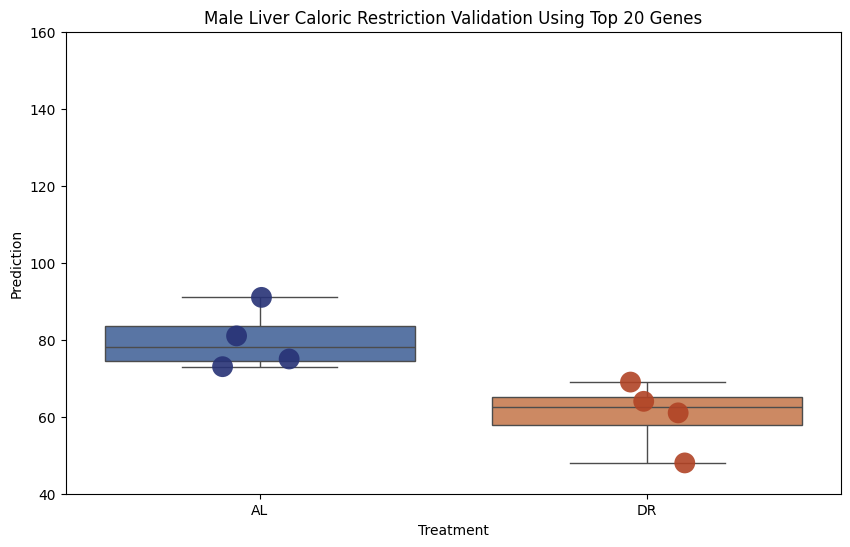

In [ ]:
# Create the box plot
random.seed(42)
plt.figure(figsize=(10, 6))
box = sns.boxplot(x='treatment', y='prediction', hue='treatment', data=liver_male_age_predictions_CR, palette='deep', showfliers = False)

# Add data points

custom_palette = ['#273276', '#B14325']  # Use desired hex color codes



# Add data points with custom colors
strip = sns.stripplot(
    x='treatment',
    y='prediction',
    hue='treatment',
    data=liver_male_age_predictions_CR,
    palette=custom_palette,  # Custom color palette
    dodge=False,
    alpha=0.9,
    jitter=True,
    size=15
)

# Remove the legend if not needed
#strip.legend_.remove()

# Customize the plot
plt.title("".join(['Male Liver Caloric Restriction Validation Using Top ', str(gene_number), ' Genes']))
plt.xlabel('Treatment')
plt.ylabel('Prediction')

# Set y-axis limits
plt.ylim(40, 160)

# Remove the grid
plt.grid(False)

plt.savefig("".join(["./plots/liver_CR_top_",str(gene_number),"_genes.svg"]), dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

In [ ]:
# Adjust to the median of the AL samples

median_AL = liver_male_age_predictions_CR[liver_male_age_predictions_CR['treatment'] == 'AL']['prediction'].median()


liver_male_age_predictions_CR["prediction_adjust"] = liver_male_age_predictions_CR["prediction"] - median_AL

liver_male_age_predictions_CR


,prediction,treatment,prediction_adjust
m_AL_L_1,81.0,AL,3.0
m_DR_L_1,61.0,DR,-17.0
m_AL_L_2,75.0,AL,-3.0
m_DR_L_2,48.0,DR,-30.0
m_DR_L_3,69.0,DR,-9.0
m_AL_L_3,73.0,AL,-5.0
m_DR_L_4,64.0,DR,-14.0
m_AL_L_4,91.0,AL,13.0


###### Fig 5F - M bayesage

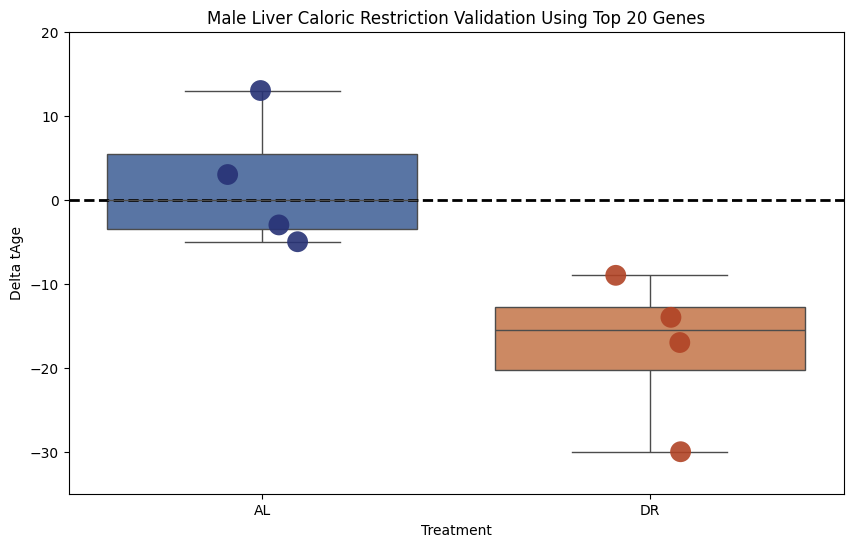

In [ ]:
# Create the box plot
random.seed(42)

plt.figure(figsize=(10, 6))
box = sns.boxplot(x='treatment', y='prediction_adjust', hue='treatment', data=liver_male_age_predictions_CR, palette='deep', showfliers = False)

# Add data points
custom_palette = ['#273276', '#B14325']  # Use desired hex color codes



# Add data points with custom colors
strip = sns.stripplot(
    x='treatment',
    y='prediction_adjust',
    hue='treatment',
    data=liver_male_age_predictions_CR,
    palette=custom_palette,  # Custom color palette
    dodge=False,
    alpha=0.9,
    jitter=True,
    size=15
)

# Remove the legend if not needed
#strip.legend_.remove()

plt.axhline(y=0, color='black', linestyle='--', linewidth=2)

# Customize the plot
plt.title("".join(['Male Liver Caloric Restriction Validation Using Top ', str(gene_number), ' Genes']))
plt.xlabel('Treatment')
plt.ylabel('Delta tAge')

# Set y-axis limits
plt.ylim(-35, 20)

# Remove the grid
plt.grid(False)

plt.savefig("".join(["./plots/Fig5f-left_liver_CR_top_",str(gene_number),"_genes_adjusttomedian.svg"]), dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

#### Get top spearman genes

In [ ]:
max_gene_number = 100

# Load and prepare reference data
reference_df = pd.read_csv(f"./references/killifish_liver_reference_male", sep="\t", index_col=0)
top_abs_spearman_corr = reference_df["spearman_rank"].abs().nlargest(max_gene_number)
top_genes = top_abs_spearman_corr.index.tolist()
print(top_genes)

top_genes_df = pd.DataFrame(top_genes, columns=["genes"])


# Save the DataFrame to a CSV file
output_path = './gene_sets/'
gene_num = "".join([str(max_gene_number), "genes"])
out_file_prefix = 'liver_spearmancorr_top'
out_file_name = "_".join([out_file_prefix, gene_num])
top_genes_df.to_csv(os.path.join(output_path, out_file_name), sep="\t")

['pax5', 'map1a', 'bcap31', 'LOC107378608', 'LOC107397330', 'LOC107382227', 'LOC107396072', 'LOC107384141', 'LOC107381561', 'wdr70', 'LOC107396996', 'LOC107379418', 'LOC107382977', 'rerg', 'nlgn2', 'LOC107388060', 'LOC107396109', 'LOC107393647', 'col1a2', 'tbx2', 'crls1', 'echdc2', 'LOC107375122', 'ckb', 'LOC107384204', 'LOC107379383', 'skida1', 'atxn2', 'LOC107391714', 'sparc', 'LOC107392322', 'LOC107374748', 'LOC107392469', 'LOC107394182', 'LOC107375713', 'LOC107388510', 'LOC107394711', 'LOC107387680', 'LOC107380370', 'LOC107377991', 'prkar1a', 'cdh17', 'LOC107374665', 'ndufb3', 'LOC107384413', 'LOC107395745', 'LOC107387253', 'mfap2', 'LOC107372647', 'LOC107375316', 'fdxr', 'lfng', 'efnb3', 'LOC107390870', 'id1', 'LOC107396744', 'anxa5', 'gpatch11', 'LOC107396733', 'LOC107388415', 'LOC107376164', 'LOC107383949', 'LOC107384867', 'slc16a4', 'LOC107377047', 'LOC107372906', 'LOC107392988', 'snai2', 'LOC107385717', 'LOC107380841', 'LOC107378794', 'LOC107374503', 'foxf1', 'gnb1l', 'col6a2'

In [ ]:
out_file_prefix = 'liver_spearmancorr_corrvals_top'
out_file_name = "_".join([out_file_prefix, gene_num])
reference_df.loc[top_genes]["spearman_rank"].to_csv(os.path.join(output_path, out_file_name), sep="\t")

#### Run Comparison Across all Gene Numbers

In [ ]:
df_metadata_cr_male = pd.DataFrame()
df_metadata_cr_male['sample'] = df_cr_age_liver_raw_counts_male.index
df_metadata_cr_male.index = df_metadata_cr_male['sample']
df_metadata_cr_male[['sex', 'feed', 'tissue', 'repl']] = df_metadata_cr_male['sample'].str.split('_', expand=True)
df_metadata_cr_male

,sample,sex,feed,tissue,repl
sample,,,,,
m_AL_L_1,m_AL_L_1,m,AL,L,1
m_DR_L_1,m_DR_L_1,m,DR,L,1
m_AL_L_2,m_AL_L_2,m,AL,L,2
m_DR_L_2,m_DR_L_2,m,DR,L,2
m_DR_L_3,m_DR_L_3,m,DR,L,3
m_AL_L_3,m_AL_L_3,m,AL,L,3
m_DR_L_4,m_DR_L_4,m,DR,L,4
m_AL_L_4,m_AL_L_4,m,AL,L,4


In [ ]:
# run the age predictions for genes in range (5-100), increments of 5, calculate delta age and plot delta age
pred_gene_steps = list(np.arange(5, 105, 5))

# Initialize dataframes for storing results
all_predictions_df = pd.DataFrame(columns=["sample","sex" ,"feed", "tissue", "repl", "prediction", "gene_number"])
summary_df = pd.DataFrame(columns=["gene_number", "mean_diff_DR_AL", "median_diff_DR_AL"])

# Load and prepare reference data
reference_df = pd.read_csv(f"./references/killifish_liver_reference_male", sep="\t", index_col=0)

for gene_number in pred_gene_steps:
    # Temporary list to store predictions for the current gene number
    temp_predictions = []

    for sample in df_cr_age_liver_raw_counts_male.index.tolist():
        top_abs_spearman_corr = reference_df["spearman_rank"].abs().nlargest(gene_number)
        top_genes = top_abs_spearman_corr.index.tolist()
        total_reads_sample = df_cr_age_liver_raw_counts_male.loc[sample].sum()
        list_of_profile_probabilities_per_age = []


        for age in male_age_steps:
          probability_list_one_age = []
          genes_not_defined = []

          for gene in top_genes:
              gene_frequency = reference_df.loc[gene, f"{age}"]
              if gene_frequency < 0:
                  gene_frequency = 10**-10
              sample_expected_counts = gene_frequency * total_reads_sample
              sample_observed_counts = df_cr_age_liver_raw_counts_male.loc[sample, gene]
              poisson_probability = poisson.pmf(k=sample_observed_counts, mu=sample_expected_counts)

              # Replace NaN poisson probability with a small positive value and log it
              if np.isnan(poisson_probability):
                  poisson_probability = 0.001
                  genes_not_defined.append(gene)

              # Replace zero poisson probability with 0.001
              if poisson_probability == 0:
                  poisson_probability = 0.001
              logP = np.log(poisson_probability)
              probability_list_one_age.append(logP)
          list_of_profile_probabilities_per_age.append(np.sum(probability_list_one_age))

        # Transform into dataframe with age steps
        age_probability_df = pd.DataFrame({"Pr": list_of_profile_probabilities_per_age}, index=male_age_steps)

        # Compute highest likelihood age among age steps
        max_probability_age = round(float(age_probability_df.idxmax().iloc[0]), 2)

        # Compute highest maximum probability
        max_probability = float(age_probability_df["Pr"].max())

        # Append prediction results for each sample to temp list
        temp_predictions.append({
            "sample": sample,
            "sex": df_metadata_cr_male.loc[sample, "sex"],
            "feed": df_metadata_cr_male.loc[sample, "feed"],
            "tissue": df_metadata_cr_male.loc[sample, "tissue"],
            "repl": df_metadata_cr_male.loc[sample, "repl"],
            "prediction": max_probability_age,
            "gene_number": gene_number
        })

    # Add current gene_number's predictions to all_predictions_df
    all_predictions_df = pd.concat([all_predictions_df, pd.DataFrame(temp_predictions)], ignore_index=True)

    # Calculate mean and median prediction differences between old and young samples
    DR_predictions = all_predictions_df[(all_predictions_df["feed"] == "DR") & (all_predictions_df["gene_number"] == gene_number)]["prediction"]
    AL_predictions = all_predictions_df[(all_predictions_df["feed"] == "AL") & (all_predictions_df["gene_number"] == gene_number)]["prediction"]

    mean_diff = DR_predictions.mean() - AL_predictions.mean()
    median_diff = DR_predictions.median() - AL_predictions.median()

    # Create a row for summary_df with the current gene_number's stats and add it using pd.concat
    summary_row = pd.DataFrame({
        "gene_number": [gene_number],
        "mean_diff_DR_AL": [mean_diff],
        "median_diff_DR_AL": [median_diff]
    })
    summary_df = pd.concat([summary_df, summary_row], ignore_index=True)

# Print the results
print(all_predictions_df)
print(summary_df)


<ipython-input-67-11b93ce55b33>:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_predictions_df = pd.concat([all_predictions_df, pd.DataFrame(temp_predictions)], ignore_index=True)
<ipython-input-67-11b93ce55b33>:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_df = pd.concat([summary_df, summary_row], ignore_index=True)


       sample sex feed tissue repl  prediction gene_number
0    m_AL_L_1   m   AL      L    1        47.0           5
1    m_DR_L_1   m   DR      L    1        51.0           5
2    m_AL_L_2   m   AL      L    2        55.0           5
3    m_DR_L_2   m   DR      L    2        57.0           5
4    m_DR_L_3   m   DR      L    3        61.0           5
..        ...  ..  ...    ...  ...         ...         ...
155  m_DR_L_2   m   DR      L    2        48.0         100
156  m_DR_L_3   m   DR      L    3        73.0         100
157  m_AL_L_3   m   AL      L    3        81.0         100
158  m_DR_L_4   m   DR      L    4        69.0         100
159  m_AL_L_4   m   AL      L    4        97.0         100

[160 rows x 7 columns]
   gene_number  mean_diff_DR_AL  median_diff_DR_AL
0            5             3.75                4.5
1           10           -14.25              -13.0
2           15           -15.75              -14.5
3           20           -19.50              -15.5
4           2

##### ExtDataFig8a -
#####Stats for Comparison across all gene_num

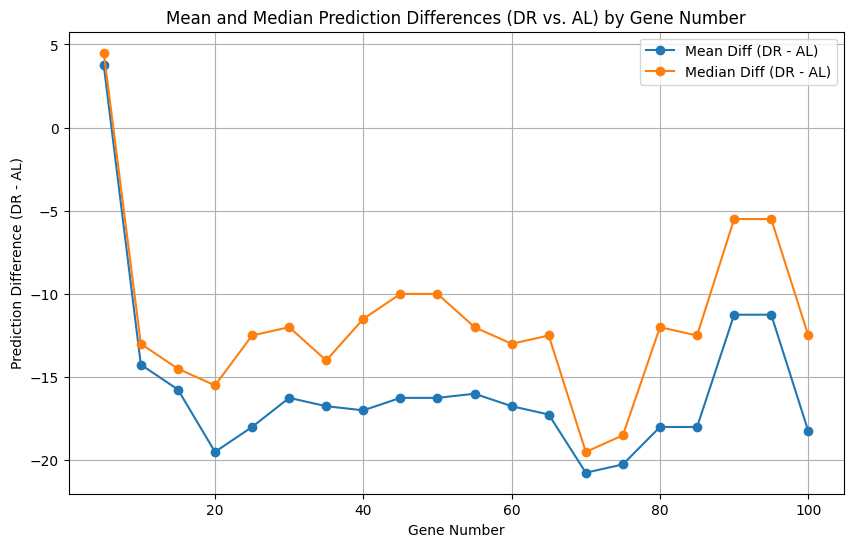

In [ ]:
# Plot mean_diff_old_young and median_diff_old_young as gene_number varies
plt.figure(figsize=(10, 6))

# Plot the mean difference
plt.plot(summary_df['gene_number'], summary_df['mean_diff_DR_AL'], label='Mean Diff (DR - AL)', marker='o')

# Plot the median difference
plt.plot(summary_df['gene_number'], summary_df['median_diff_DR_AL'], label='Median Diff (DR - AL)', marker='o')

# Add labels and title
plt.xlabel('Gene Number')
plt.ylabel('Prediction Difference (DR - AL)')
plt.title('Mean and Median Prediction Differences (DR vs. AL) by Gene Number')
plt.legend()
plt.grid(True)

plt.savefig("".join(["./plots/ExtDataFig8a_liver_male_McKay_male_DR-vs-AL_deltaAge_5-100genes.svg"]), dpi=300, bbox_inches="tight")


plt.show()


In [ ]:
import pandas as pd
from scipy.stats import ks_2samp, mannwhitneyu

df = all_predictions_df.copy()


# Function to calculate percentage overlap
def percentage_overlap(values1, values2):
    min1, max1 = min(values1), max(values1)
    min2, max2 = min(values2), max(values2)
    overlap_range = max(0, min(max1, max2) - max(min1, min2))
    total_range = max(max1, max2) - min(min1, min2)
    return overlap_range / total_range if total_range > 0 else 0

# Create a DataFrame to store results
results = []

# Iterate over unique gene numbers
for gene_number in df['gene_number'].unique():
    # Subset data for the specific gene number
    subset = df[df['gene_number'] == gene_number]
    al_values = subset[subset['feed'] == 'AL']['prediction']
    dr_values = subset[subset['feed'] == 'DR']['prediction']

    # Perform KS test
    ks_stat, ks_pvalue = ks_2samp(al_values, dr_values)

    # Perform Mann-Whitney U test
    mw_stat, mw_pvalue = mannwhitneyu(al_values, dr_values, alternative='two-sided')

    # Calculate Percentage Overlap
    overlap = percentage_overlap(al_values, dr_values)

    # Append results
    results.append({
        'gene_number': gene_number,
        'ks_stat': ks_stat,
        'ks_pvalue': ks_pvalue,
        'mw_stat': mw_stat,
        'mw_pvalue': mw_pvalue,
        'percentage_overlap': overlap
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display or save results
print(results_df)

    gene_number  ks_stat  ks_pvalue  mw_stat  mw_pvalue  percentage_overlap
0             5     0.50   0.771429      5.0   0.459597            0.571429
1            10     1.00   0.028571     16.0   0.028571            0.000000
2            15     0.75   0.228571     14.5   0.081429            0.128205
3            20     1.00   0.028571     16.0   0.028571            0.000000
4            25     1.00   0.028571     16.0   0.029401            0.000000
5            30     0.75   0.228571     15.0   0.057143            0.046512
6            35     0.75   0.228571     15.0   0.057143            0.093023
7            40     1.00   0.028571     16.0   0.029401            0.000000
8            45     1.00   0.028571     16.0   0.029401            0.000000
9            50     1.00   0.028571     16.0   0.029401            0.000000
10           55     0.75   0.228571     15.0   0.057143            0.069767
11           60     0.75   0.228571     15.0   0.059072            0.046512
12          

###### ExtDataFig8c

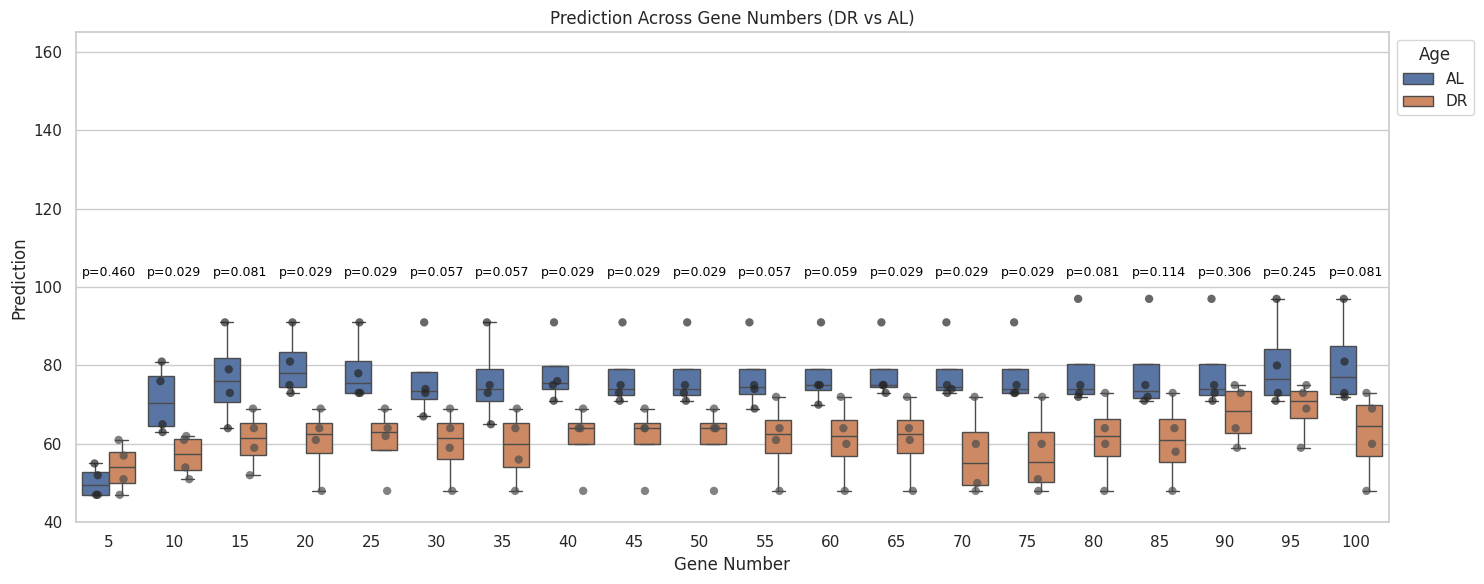

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(42)
min_value = 40
max_value = 165

# Create the plot
plt.figure(figsize=(15, 6))
sns.set(style="whitegrid")

# Create a boxplot with paired 6.5weeks and 15weeks comparisons for each gene_number
sns.boxplot(
    data=df,
    x="gene_number",
    y="prediction",
    hue="feed",
    palette=hex_codes[0:2],
    showfliers=False
)

# Add individual points for each sample with the same age order
sns.stripplot(
    data=df,
    x="gene_number",
    y="prediction",
    hue="feed",
    dodge=True,
    palette="dark:.3",
    size=6,
    jitter=True,
    alpha=0.7
)

# Add p-values as annotations for each gene_number
gene_numbers = results_df["gene_number"].unique()
for i in range(len(gene_numbers)):
    gene_number = gene_numbers[i]
    mw_pvalue = results_df.loc[results_df["gene_number"] == gene_number, "mw_pvalue"].values[0]
    x_position = i   # Adjust to match the x-axis position of the boxplot
    plt.text(x=x_position, y=df["prediction"].max() + 5,  # Position slightly above the max prediction
             s=f"p={mw_pvalue:.3f}",
             ha="center", va="bottom", fontsize=9, color="black", rotation=0)

# Adjust the legend to remove duplicates
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title="Age", loc="upper left", bbox_to_anchor=(1, 1))

# Add titles and labels
plt.title("Prediction Across Gene Numbers (DR vs AL)")
plt.xlabel("Gene Number")
plt.ylabel("Prediction")
plt.ylim(min_value, max_value)

# Show the plot
plt.tight_layout()

# Save the plot
plt.savefig("./plots/ExtDataFig8c_liver_male_McKay_DR-vs-AL_boxplot_5-100genes.svg", dpi=300, bbox_inches="tight")

plt.show()


### Difference between Means

In [ ]:
# Separate predictions by treatment

mean_AL = liver_male_age_predictions_CR[liver_male_age_predictions_CR['treatment'] == 'AL']['prediction'].mean()
mean_DR = liver_male_age_predictions_CR[liver_male_age_predictions_CR['treatment'] == 'DR']['prediction'].mean()

# Calculate the differences btwn means (meanDR - meanAL)
mean_difference = mean_AL - mean_DR

mean_difference

19.5

### Difference between Medians

In [ ]:
# Separate predictions by treatment

median_AL = liver_male_age_predictions_CR[liver_male_age_predictions_CR['treatment'] == 'AL']['prediction'].median()
median_DR = liver_male_age_predictions_CR[liver_male_age_predictions_CR['treatment'] == 'DR']['prediction'].median()

# Calculate the differences btwn medians (medianDR - medianAL)
median_difference = median_AL - median_DR

median_difference

15.5

In [ ]:
# Assuming your DataFrame is `liver_male_age_predictions_CR`
# Replace 'prediction' and 'treatment' with the exact column names in your DataFrame

# Filter and convert 'prediction' values to numeric, forcing non-numeric to NaN
AL_values = pd.to_numeric(
    liver_male_age_predictions_CR[liver_male_age_predictions_CR['treatment'] == 'AL']['prediction'],
    errors='coerce'
)
DR_values = pd.to_numeric(
    liver_male_age_predictions_CR[liver_male_age_predictions_CR['treatment'] == 'DR']['prediction'],
    errors='coerce'
)

# Drop NaN values from each group
AL_values = AL_values.dropna()
DR_values = DR_values.dropna()

# Perform Mann-Whitney U test if both groups are non-empty
if not AL_values.empty and not DR_values.empty:
    stat, p_value = mannwhitneyu(AL_values, DR_values, alternative='two-sided')
    print("Mann-Whitney U test results:")
    print(f"Statistic: {stat}, p-value: {p_value}")
else:
    print("One or both groups are empty after filtering NaN values.")


Mann-Whitney U test results:
Statistic: 16.0, p-value: 0.02857142857142857


In [ ]:
AL_values

,prediction
m_AL_L_1,81.0
m_AL_L_2,75.0
m_AL_L_3,73.0
m_AL_L_4,91.0


In [ ]:
DR_values

,prediction
m_DR_L_1,61.0
m_DR_L_2,48.0
m_DR_L_3,69.0
m_DR_L_4,64.0


In [ ]:
p_values = []

# Example datasets for multiple comparisons
data_groups = {
    'AL_DR': (AL_values, DR_values),
}

# Perform tests and collect p-values
for name, (group1, group2) in data_groups.items():
    # Perform Mann-Whitney U test
    stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
    p_values.append(p_value)

# Apply FDR correction (Benjamini-Hochberg)
adjusted_p_values = multipletests(p_values, alpha=0.05, method='fdr_bh')[1]

# Display adjusted p-values
for i, (name, (group1, group2)) in enumerate(data_groups.items()):
    print(f"{name} comparison:")
    print(f"Original p-value: {p_values[i]}, Adjusted p-value: {adjusted_p_values[i]}")


AL_DR comparison:
Original p-value: 0.02857142857142857, Adjusted p-value: 0.02857142857142857


### Female

#### Female Transcriptome Reference

In [ ]:
liver_df_female = liver_df.loc[liver_df.iloc[:,-3] == "F"]

In [ ]:
liver_df_female["age_days"].value_counts()

,count
age_days,
52,2
133,2
102,2
134,2
147,2
78,2
47,2
49,2
75,2


In [ ]:
liver_df_female.head(5)

,a1cf,aaas,aacs,aadat,aaed1,aagab,aak1,aamdc,aamp,aar2,...,zufsp,zw10,zwilch,zyg11b,zyx,zzef1,zzz3,sex,tissue,age_days
A6_1,43882.858900,853.088237,19132.800486,1147.075568,81.371493,1433.188238,1212.697740,1622.180093,1532.933939,713.969232,...,118.119910,2543.515389,307.111765,425.231675,2302.025796,782.216291,577.475114,F,Liver,52
A7_1,46308.620187,503.876178,3746.507910,867.215463,126.825977,1144.861521,1357.380725,1669.304073,970.047336,647.840801,...,41.132749,3033.540256,3.427729,414.755222,3191.215795,586.141677,661.551717,F,Liver,133
B5_1,50060.335020,509.903707,3616.007271,556.585032,32.317841,1037.761769,1052.125254,1658.982482,1138.306162,621.220713,...,25.136098,2007.296986,3.590871,373.450602,2330.475391,570.948516,416.541056,F,Liver,102
B6_1,52010.405793,439.314180,3444.223173,593.074143,74.683411,1107.071734,926.952920,1555.172198,760.013532,733.654681,...,39.538276,3088.378687,4.393142,487.638740,1871.478408,505.211307,544.749583,F,Liver,134
B8_1,57870.342592,385.596632,4719.702781,704.356515,66.836750,776.334553,1033.398975,1269.898243,1043.681552,622.095900,...,87.401903,2035.950219,35.989019,493.563689,1300.745973,426.726940,483.281113,F,Liver,133


In [ ]:
age_days_value_counts = liver_df_female["age_days"].value_counts().index.tolist()

print(sorted(age_days_value_counts))

[47, 49, 52, 75, 77, 78, 102, 103, 133, 134, 147, 155]


In [ ]:
liver_gene_expression_data_female = liver_df_female.iloc[:, :-3]

In [ ]:
liver_df_female_age = liver_gene_expression_data_female.copy()

liver_df_female_age.head(3)

,a1cf,aaas,aacs,aadat,aaed1,aagab,aak1,aamdc,aamp,aar2,...,zswim6,zswim7,zswim8,zufsp,zw10,zwilch,zyg11b,zyx,zzef1,zzz3
A6_1,43882.858900,853.088237,19132.800486,1147.075568,81.371493,1433.188238,1212.697740,1622.180093,1532.933939,713.969232,...,181.117195,191.616742,1007.956563,118.119910,2543.515389,307.111765,425.231675,2302.025796,782.216291,577.475114
A7_1,46308.620187,503.876178,3746.507910,867.215463,126.825977,1144.861521,1357.380725,1669.304073,970.047336,647.840801,...,140.536893,202.236017,1336.814350,41.132749,3033.540256,3.427729,414.755222,3191.215795,586.141677,661.551717
B5_1,50060.335020,509.903707,3616.007271,556.585032,32.317841,1037.761769,1052.125254,1658.982482,1138.306162,621.220713,...,118.498749,157.998332,1116.760935,25.136098,2007.296986,3.590871,373.450602,2330.475391,570.948516,416.541056


In [ ]:
liver_df_female_age["age"] = liver_df_female["age_days"].tolist()

liver_df_female_age.head(3)

,a1cf,aaas,aacs,aadat,aaed1,aagab,aak1,aamdc,aamp,aar2,...,zswim7,zswim8,zufsp,zw10,zwilch,zyg11b,zyx,zzef1,zzz3,age
A6_1,43882.858900,853.088237,19132.800486,1147.075568,81.371493,1433.188238,1212.697740,1622.180093,1532.933939,713.969232,...,191.616742,1007.956563,118.119910,2543.515389,307.111765,425.231675,2302.025796,782.216291,577.475114,52
A7_1,46308.620187,503.876178,3746.507910,867.215463,126.825977,1144.861521,1357.380725,1669.304073,970.047336,647.840801,...,202.236017,1336.814350,41.132749,3033.540256,3.427729,414.755222,3191.215795,586.141677,661.551717,133
B5_1,50060.335020,509.903707,3616.007271,556.585032,32.317841,1037.761769,1052.125254,1658.982482,1138.306162,621.220713,...,157.998332,1116.760935,25.136098,2007.296986,3.590871,373.450602,2330.475391,570.948516,416.541056,102


In [ ]:
female_age_steps = list(np.arange(47, 156, 1))

In [ ]:
transcriptome_reference(training_matrix="./inputs/killifish_liver_female.csv",
                             reference_name=f"killifish_liver_reference_female",
                             output_path="./references/",
                             age_prediction="list",
                             age_list=female_age_steps,
                             min_age=1,
                             max_age=24,
                             age_step=1,
                             tau=0.7)


Reference model dataset written to './references/killifish_liver_reference_female'
Report file generated at './references/killifish_liver_reference_female.report.txt'
-----------------------------------------------------



Time to run construct reference: 134.675 seconds

The reference is constructed and saved!


,47,48,49,50,51,52,53,54,55,56,...,148,149,150,151,152,153,154,155,spearman_rank,p_value
Gene,,,,,,,,,,,,,,,,,,,,,
a1cf,4.536794e-04,4.548267e-04,4.559737e-04,4.571202e-04,4.582667e-04,4.594134e-04,4.605608e-04,4.617091e-04,4.628582e-04,4.640082e-04,...,5.581683e-04,5.597972e-04,5.614553e-04,5.631413e-04,5.648540e-04,5.665921e-04,5.683542e-04,5.701390e-04,0.391877,0.064410
aaas,6.964885e-06,6.927938e-06,6.891251e-06,6.854863e-06,6.818809e-06,6.783123e-06,6.747830e-06,6.712942e-06,6.678458e-06,6.644381e-06,...,5.291597e-06,5.296875e-06,5.302744e-06,5.309216e-06,5.316300e-06,5.324005e-06,5.332339e-06,5.341309e-06,-0.226902,0.297802
aacs,1.007632e-04,9.957617e-05,9.838318e-05,9.718530e-05,9.598335e-05,9.477810e-05,9.357020e-05,9.235983e-05,9.114703e-05,8.993185e-05,...,7.138926e-05,7.267254e-05,7.396370e-05,7.526261e-05,7.656912e-05,7.788308e-05,7.920432e-05,8.053268e-05,-0.125341,0.568781
aadat,7.876147e-06,7.842019e-06,7.808342e-06,7.775165e-06,7.742520e-06,7.710432e-06,7.678926e-06,7.648012e-06,7.617696e-06,7.587984e-06,...,7.371142e-06,7.372899e-06,7.374981e-06,7.377374e-06,7.380066e-06,7.383043e-06,7.386291e-06,7.389795e-06,-0.028239,0.898227
aaed1,6.781539e-07,6.797669e-07,6.814074e-07,6.830758e-07,6.847731e-07,6.865006e-07,6.882594e-07,6.900506e-07,6.918752e-07,6.937342e-07,...,8.188080e-07,8.156256e-07,8.123973e-07,8.091274e-07,8.058204e-07,8.024806e-07,7.991126e-07,7.957205e-07,0.103047,0.639866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zwilch,6.138844e-07,6.029404e-07,5.920251e-07,5.811392e-07,5.702826e-07,5.594552e-07,5.486568e-07,5.378871e-07,5.271459e-07,5.164328e-07,...,1.998519e-07,2.022957e-07,2.047375e-07,2.071762e-07,2.096106e-07,2.120399e-07,2.144628e-07,2.168784e-07,-0.334903,0.118270
zyg11b,4.303581e-06,4.311979e-06,4.320437e-06,4.328954e-06,4.337525e-06,4.346142e-06,4.354796e-06,4.363489e-06,4.372220e-06,4.380992e-06,...,4.681516e-06,4.686958e-06,4.692792e-06,4.699009e-06,4.705600e-06,4.712554e-06,4.719862e-06,4.727513e-06,0.105524,0.631799
zyx,2.753898e-05,2.747118e-05,2.740434e-05,2.733848e-05,2.727356e-05,2.720952e-05,2.714631e-05,2.708393e-05,2.702240e-05,2.696171e-05,...,2.624478e-05,2.630350e-05,2.636444e-05,2.642774e-05,2.649348e-05,2.656177e-05,2.663269e-05,2.670634e-05,-0.089671,0.684092


#### Age Prediction

In [ ]:
df_cr_age_liver_female = df_cr_age_liver[df_cr_age_liver["sex"] == "f"]

df_cr_age_liver_female.head(5)

,LOC107375582,LOC107388276,LOC107382448,LOC107377727,pex1,LOC107393665,LOC107377394,zbtb41,LOC107397029,LOC107377691,...,LOC107372821,LOC107386901,LOC107386251,LOC107378151,dag1,LOC107396310,LOC107378249,treatment,tissue,sex
f_AL_L_1,0,0,1,176,142,8,0,94,0,385,...,771,2,559,0,20,38,77,AL,Liver,f
f_AL_L_2,0,0,0,6,127,2,2,18,0,275,...,634,2,195,0,26,4,24,AL,Liver,f
f_DR_L_1,0,0,0,18,455,38,0,148,0,226,...,3009,0,458,16,16,14,15,DR,Liver,f
f_DR_L_2,0,0,0,36,241,24,0,144,0,276,...,1908,6,304,8,20,4,72,DR,Liver,f
f_AL_L_3,0,0,0,33,336,8,4,112,0,211,...,1204,4,370,10,24,6,59,AL,Liver,f


In [ ]:
df_cr_age_liver_raw_counts_female = df_cr_age_liver_female.iloc[:,:-3]

df_cr_age_liver_raw_counts_female.head(5)

,LOC107375582,LOC107388276,LOC107382448,LOC107377727,pex1,LOC107393665,LOC107377394,zbtb41,LOC107397029,LOC107377691,...,LOC107393324,chp1,LOC107392884,LOC107372821,LOC107386901,LOC107386251,LOC107378151,dag1,LOC107396310,LOC107378249
f_AL_L_1,0,0,1,176,142,8,0,94,0,385,...,2,1369,0,771,2,559,0,20,38,77
f_AL_L_2,0,0,0,6,127,2,2,18,0,275,...,0,3469,0,634,2,195,0,26,4,24
f_DR_L_1,0,0,0,18,455,38,0,148,0,226,...,0,2136,0,3009,0,458,16,16,14,15
f_DR_L_2,0,0,0,36,241,24,0,144,0,276,...,0,1632,0,1908,6,304,8,20,4,72
f_AL_L_3,0,0,0,33,336,8,4,112,0,211,...,0,4877,0,1204,4,370,10,24,6,59


In [ ]:
df_cr_liver_raw_counts_freq_female = df_cr_age_liver_raw_counts_female.copy()

df_cr_liver_raw_counts_freq_female = df_cr_liver_raw_counts_freq_female.div(df_cr_liver_raw_counts_freq_female.sum(axis=1), axis=0)

df_cr_liver_raw_counts_freq_female.head(5)

,LOC107375582,LOC107388276,LOC107382448,LOC107377727,pex1,LOC107393665,LOC107377394,zbtb41,LOC107397029,LOC107377691,...,LOC107393324,chp1,LOC107392884,LOC107372821,LOC107386901,LOC107386251,LOC107378151,dag1,LOC107396310,LOC107378249
f_AL_L_1,0.0,0.0,3.233129e-08,5.690306e-06,0.000005,2.586503e-07,0.000000e+00,3.039141e-06,0.0,0.000012,...,6.466257e-08,0.000044,0.0,0.000025,6.466257e-08,0.000018,0.000000e+00,6.466257e-07,1.228589e-06,2.489509e-06
f_AL_L_2,0.0,0.0,0.000000e+00,1.953510e-07,0.000004,6.511701e-08,6.511701e-08,5.860531e-07,0.0,0.000009,...,0.000000e+00,0.000113,0.0,0.000021,6.511701e-08,0.000006,0.000000e+00,8.465211e-07,1.302340e-07,7.814041e-07
f_DR_L_1,0.0,0.0,0.000000e+00,5.372116e-07,0.000014,1.134113e-06,0.000000e+00,4.417073e-06,0.0,0.000007,...,0.000000e+00,0.000064,0.0,0.000090,0.000000e+00,0.000014,4.775214e-07,4.775214e-07,4.178313e-07,4.476763e-07
f_DR_L_2,0.0,0.0,0.000000e+00,1.094266e-06,0.000007,7.295104e-07,0.000000e+00,4.377062e-06,0.0,0.000008,...,0.000000e+00,0.000050,0.0,0.000058,1.823776e-07,0.000009,2.431701e-07,6.079253e-07,1.215851e-07,2.188531e-06
f_AL_L_3,0.0,0.0,0.000000e+00,9.512905e-07,0.000010,2.306159e-07,1.153079e-07,3.228622e-06,0.0,0.000006,...,0.000000e+00,0.000141,0.0,0.000035,1.153079e-07,0.000011,2.882698e-07,6.918476e-07,1.729619e-07,1.700792e-06


#### One gene number

In [ ]:
gene_number = 20

In [ ]:
liver_female_age_predictions_CR = pd.DataFrame(index=df_cr_age_liver_raw_counts_female.index, columns=["prediction"])

# Read the spearman and frequency data for the current sample
reference_df = pd.read_csv(f"./references/killifish_liver_reference_female", sep="\t", index_col=0)

for sample in df_cr_age_liver_raw_counts_female.index.tolist():

    # Get top genes based on spearman correlation
    top_abs_spearman_corr = reference_df["spearman_rank"].abs().nlargest(gene_number)

    # Save the DataFrame to a CSV file
    df_top_genes = pd.DataFrame(top_genes, columns=["genes"])
    gene_num = "".join([str(gene_number), "genes"])
    out_file_prefix = 'ALDR_female_pred'
    out_file_name = "_".join([out_file_prefix, gene_num])
    output_path = './gene_sets'
    df_top_genes.to_csv(os.path.join(output_path, out_file_name), sep="\t")
    print(f"List has been written to {out_file_name}")

    #print(top_abs_spearman_corr)

    top_genes = top_abs_spearman_corr.index.tolist()

    total_reads_sample = df_cr_age_liver_raw_counts_female.loc[sample].sum()

    list_of_profile_probabilities_per_age = []

    for age in female_age_steps:

        probability_list_one_age = []

        genes_not_defined = []

        for gene in top_genes:

            gene_frequency = reference_df.loc[gene, f"{age}"]

            if gene_frequency < 0:
                gene_frequency = 10**-10

            sample_expected_counts = gene_frequency * total_reads_sample
            sample_observed_counts = df_cr_age_liver_raw_counts_female.loc[sample, gene]

            poisson_probability = poisson.pmf(k=sample_observed_counts, mu=sample_expected_counts)

            # Replace NaN poisson probability with a small positive value and log it
            if np.isnan(poisson_probability):
                poisson_probability = 0.001
                genes_not_defined.append(gene)

            # Replace zero poisson probability with 0.001
            if poisson_probability == 0:
                poisson_probability = 0.001

            logP = np.log(poisson_probability)

            probability_list_one_age.append(logP)

        list_of_profile_probabilities_per_age.append(np.sum(probability_list_one_age))

    # Transform into dataframe with age steps
    age_probability_df = pd.DataFrame({"Pr": list_of_profile_probabilities_per_age}, index=female_age_steps)

    # Compute highest likelihood age among age steps
    max_probability_age = round(float(age_probability_df.idxmax().iloc[0]), 2)

    # Compute highest maximum probability
    # max_probability = float(age_probability_df["Pr"].max())

    liver_female_age_predictions_CR.loc[sample, "prediction"] = max_probability_age

print(liver_female_age_predictions_CR)

List has been written to ALDR_female_pred_20genes
List has been written to ALDR_female_pred_20genes
List has been written to ALDR_female_pred_20genes
List has been written to ALDR_female_pred_20genes
List has been written to ALDR_female_pred_20genes
List has been written to ALDR_female_pred_20genes
List has been written to ALDR_female_pred_20genes
List has been written to ALDR_female_pred_20genes
         prediction
f_AL_L_1      155.0
f_AL_L_2       92.0
f_DR_L_1       57.0
f_DR_L_2       93.0
f_AL_L_3       82.0
f_AL_L_4      123.0
f_DR_L_3       91.0
f_DR_L_4      143.0


In [ ]:
liver_female_age_predictions_CR["treatment"] = df_cr_age_liver_female["treatment"].tolist()

In [ ]:
liver_female_age_predictions_CR

# Save the DataFrame to a CSV file
# output_path = './predictions/'
# gene_num = "".join([str(gene_number), "genes"])
# out_file_prefix = 'ALDR_liver_female_pred'
# out_file_name = "_".join([out_file_prefix, gene_num])
# liver_female_age_predictions_CR.to_csv(os.path.join(output_path, out_file_name), sep="\t")

,prediction,treatment
f_AL_L_1,155.0,AL
f_AL_L_2,92.0,AL
f_DR_L_1,57.0,DR
f_DR_L_2,93.0,DR
f_AL_L_3,82.0,AL
f_AL_L_4,123.0,AL
f_DR_L_3,91.0,DR
f_DR_L_4,143.0,DR


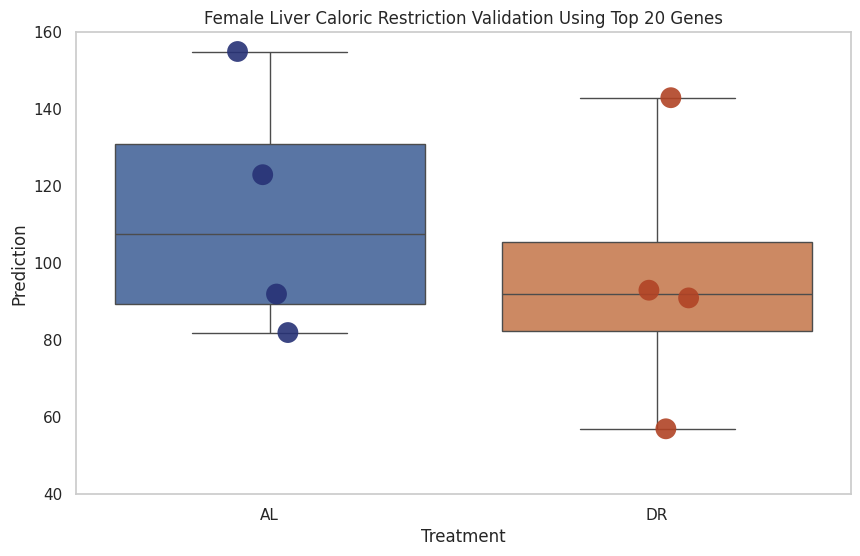

In [ ]:
# Create the box plot
random.seed(42)

plt.figure(figsize=(10, 6))
box = sns.boxplot(x='treatment', y='prediction', hue='treatment', data=liver_female_age_predictions_CR, palette='deep', showfliers = False, whis = [0,100])

# Add data points
custom_palette = ['#273276', '#B14325']  # Use desired hex color codes


# Add data points with custom colors
strip = sns.stripplot(
    x='treatment',
    y='prediction',
    hue='treatment',
    data=liver_female_age_predictions_CR,
    palette=custom_palette,  # Custom color palette
    dodge=False,
    alpha=0.9,
    jitter=True,
    size=15
)

# Remove the legend if not needed
#strip.legend_.remove()

# Customize the plot
plt.title("".join(['Female Liver Caloric Restriction Validation Using Top ', str(gene_number), ' Genes']))
plt.xlabel('Treatment')
plt.ylabel('Prediction')

# Set y-axis limits
plt.ylim(40, 160)

# Remove the grid
plt.grid(False)

plt.savefig("".join(["./plots/liver_CR_female_top_",str(gene_number),"_genes.svg"]), dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

In [ ]:
# Adjust to the median of the AL samples

median_AL = liver_female_age_predictions_CR[liver_female_age_predictions_CR['treatment'] == 'AL']['prediction'].median()


liver_female_age_predictions_CR["prediction_adjust"] = liver_female_age_predictions_CR["prediction"] - median_AL

liver_female_age_predictions_CR


,prediction,treatment,prediction_adjust
f_AL_L_1,155.0,AL,47.5
f_AL_L_2,92.0,AL,-15.5
f_DR_L_1,57.0,DR,-50.5
f_DR_L_2,93.0,DR,-14.5
f_AL_L_3,82.0,AL,-25.5
f_AL_L_4,123.0,AL,15.5
f_DR_L_3,91.0,DR,-16.5
f_DR_L_4,143.0,DR,35.5


###### Fig 5F - F bayesage

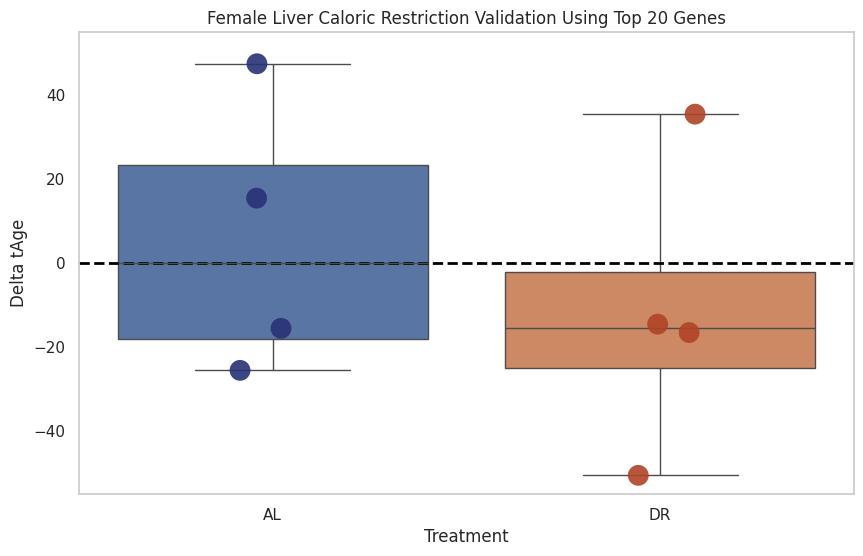

In [ ]:
# Create the box plot
random.seed(42)

plt.figure(figsize=(10, 6))
box = sns.boxplot(x='treatment', y='prediction_adjust', hue='treatment', data=liver_female_age_predictions_CR, palette='deep', showfliers = False, whis = [0,100])

# Add data points
custom_palette = ['#273276', '#B14325']  # Use desired hex color codes



# Add data points with custom colors
strip = sns.stripplot(
    x='treatment',
    y='prediction_adjust',
    hue='treatment',
    data=liver_female_age_predictions_CR,
    palette=custom_palette,  # Custom color palette
    dodge=False,
    alpha=0.9,
    jitter=True,
    size=15
)

# Remove the legend if not needed
#strip.legend_.remove()

plt.axhline(y=0, color='black', linestyle='--', linewidth=2)

# Customize the plot
#plt.title('Male Liver Caloric Restriction Validation Using Top 15 Spearman Ranked Genes')
plt.title("".join(['Female Liver Caloric Restriction Validation Using Top ', str(gene_number), ' Genes']))
plt.xlabel('Treatment')
plt.ylabel('Delta tAge')

# Set y-axis limits
plt.ylim(-55, 55)

# Remove the grid
plt.grid(False)

plt.savefig("".join(["./plots/Fig5f-liver_female_CR_top_",str(gene_number),"_genes_adjusttomedian_redo.svg"]), dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

#### Run Comparison Across all Gene Numbers

In [ ]:
df_metadata_cr_female = pd.DataFrame()
df_metadata_cr_female['sample'] = df_cr_age_liver_raw_counts_female.index
df_metadata_cr_female.index = df_metadata_cr_female['sample']
df_metadata_cr_female[['sex', 'feed', 'tissue', 'repl']] = df_metadata_cr_female['sample'].str.split('_', expand=True)
df_metadata_cr_female

,sample,sex,feed,tissue,repl
sample,,,,,
f_AL_L_1,f_AL_L_1,f,AL,L,1
f_AL_L_2,f_AL_L_2,f,AL,L,2
f_DR_L_1,f_DR_L_1,f,DR,L,1
f_DR_L_2,f_DR_L_2,f,DR,L,2
f_AL_L_3,f_AL_L_3,f,AL,L,3
f_AL_L_4,f_AL_L_4,f,AL,L,4
f_DR_L_3,f_DR_L_3,f,DR,L,3
f_DR_L_4,f_DR_L_4,f,DR,L,4


In [ ]:
# Remove multiple columns
#df_cr_age_liver_raw_counts_female = df_cr_age_liver_raw_counts_female.drop(columns=['treatment', 'tissue', 'sex'])

df_cr_age_liver_raw_counts_female.head(5)


,LOC107375582,LOC107388276,LOC107382448,LOC107377727,pex1,LOC107393665,LOC107377394,zbtb41,LOC107397029,LOC107377691,...,LOC107393324,chp1,LOC107392884,LOC107372821,LOC107386901,LOC107386251,LOC107378151,dag1,LOC107396310,LOC107378249
f_AL_L_1,0,0,1,176,142,8,0,94,0,385,...,2,1369,0,771,2,559,0,20,38,77
f_AL_L_2,0,0,0,6,127,2,2,18,0,275,...,0,3469,0,634,2,195,0,26,4,24
f_DR_L_1,0,0,0,18,455,38,0,148,0,226,...,0,2136,0,3009,0,458,16,16,14,15
f_DR_L_2,0,0,0,36,241,24,0,144,0,276,...,0,1632,0,1908,6,304,8,20,4,72
f_AL_L_3,0,0,0,33,336,8,4,112,0,211,...,0,4877,0,1204,4,370,10,24,6,59


In [ ]:
reference_df = pd.read_csv(f"./references/killifish_liver_reference_female", sep="\t", index_col=0)
reference_df.head(5)

,47,48,49,50,51,52,53,54,55,56,...,148,149,150,151,152,153,154,155,spearman_rank,p_value
Gene,,,,,,,,,,,,,,,,,,,,,
a1cf,4.536794e-04,4.548267e-04,4.559737e-04,4.571202e-04,4.582667e-04,4.594134e-04,4.605608e-04,4.617091e-04,4.628582e-04,4.640082e-04,...,5.581683e-04,5.597972e-04,5.614553e-04,5.631413e-04,5.648540e-04,5.665921e-04,5.683542e-04,5.701390e-04,0.391877,0.064410
aaas,6.964885e-06,6.927938e-06,6.891251e-06,6.854863e-06,6.818809e-06,6.783123e-06,6.747830e-06,6.712942e-06,6.678458e-06,6.644381e-06,...,5.291597e-06,5.296875e-06,5.302744e-06,5.309216e-06,5.316300e-06,5.324005e-06,5.332339e-06,5.341309e-06,-0.226902,0.297802
aacs,1.007632e-04,9.957617e-05,9.838318e-05,9.718530e-05,9.598335e-05,9.477810e-05,9.357020e-05,9.235983e-05,9.114703e-05,8.993185e-05,...,7.138926e-05,7.267254e-05,7.396370e-05,7.526261e-05,7.656912e-05,7.788308e-05,7.920432e-05,8.053268e-05,-0.125341,0.568781
aadat,7.876147e-06,7.842019e-06,7.808342e-06,7.775165e-06,7.742520e-06,7.710432e-06,7.678926e-06,7.648012e-06,7.617696e-06,7.587984e-06,...,7.371142e-06,7.372899e-06,7.374981e-06,7.377374e-06,7.380066e-06,7.383043e-06,7.386291e-06,7.389795e-06,-0.028239,0.898227
aaed1,6.781539e-07,6.797669e-07,6.814074e-07,6.830758e-07,6.847731e-07,6.865006e-07,6.882594e-07,6.900506e-07,6.918752e-07,6.937342e-07,...,8.188080e-07,8.156256e-07,8.123973e-07,8.091274e-07,8.058204e-07,8.024806e-07,7.991126e-07,7.957205e-07,0.103047,0.639866


In [ ]:
# run the age predictions for genes in range (5-100), increments of 5, calculate delta age and plot delta age
pred_gene_steps = list(np.arange(5, 105, 5))

# Initialize dataframes for storing results
all_predictions_df = pd.DataFrame(columns=["sample","sex" ,"feed", "tissue", "repl", "prediction", "gene_number"])
summary_df = pd.DataFrame(columns=["gene_number", "mean_diff_DR_AL", "median_diff_DR_AL"])

# Load and prepare reference data
reference_df = pd.read_csv(f"./references/killifish_liver_reference_female", sep="\t", index_col=0)

for gene_number in pred_gene_steps:
    # Temporary list to store predictions for the current gene number
    temp_predictions = []

    for sample in df_cr_age_liver_raw_counts_female.index.tolist():
        top_abs_spearman_corr = reference_df["spearman_rank"].abs().nlargest(gene_number)
        top_genes = top_abs_spearman_corr.index.tolist()
        total_reads_sample = df_cr_age_liver_raw_counts_female.loc[sample].sum()
        list_of_profile_probabilities_per_age = []


        for age in female_age_steps:
          probability_list_one_age = []
          genes_not_defined = []

          for gene in top_genes:
              gene_frequency = reference_df.loc[gene, f"{age}"]
              if gene_frequency < 0:
                  gene_frequency = 10**-10
              sample_expected_counts = gene_frequency * total_reads_sample
              sample_observed_counts = df_cr_age_liver_raw_counts_female.loc[sample, gene]
              poisson_probability = poisson.pmf(k=sample_observed_counts, mu=sample_expected_counts)

              # Replace NaN poisson probability with a small positive value and log it
              if np.isnan(poisson_probability):
                  poisson_probability = 0.001
                  genes_not_defined.append(gene)

              # Replace zero poisson probability with 0.001
              if poisson_probability == 0:
                  poisson_probability = 0.001
              logP = np.log(poisson_probability)
              probability_list_one_age.append(logP)
          list_of_profile_probabilities_per_age.append(np.sum(probability_list_one_age))

        # Transform into dataframe with age steps
        age_probability_df = pd.DataFrame({"Pr": list_of_profile_probabilities_per_age}, index=female_age_steps)

        # Compute highest likelihood age among age steps
        max_probability_age = round(float(age_probability_df.idxmax().iloc[0]), 2)

        # Compute highest maximum probability
        max_probability = float(age_probability_df["Pr"].max())

        # Append prediction results for each sample to temp list
        temp_predictions.append({
            "sample": sample,
            "sex": df_metadata_cr_female.loc[sample, "sex"],
            "feed": df_metadata_cr_female.loc[sample, "feed"],
            "tissue": df_metadata_cr_female.loc[sample, "tissue"],
            "repl": df_metadata_cr_female.loc[sample, "repl"],
            "prediction": max_probability_age,
            "gene_number": gene_number
        })

    # Add current gene_number's predictions to all_predictions_df
    all_predictions_df = pd.concat([all_predictions_df, pd.DataFrame(temp_predictions)], ignore_index=True)

    # Calculate mean and median prediction differences between old and young samples
    DR_predictions = all_predictions_df[(all_predictions_df["feed"] == "DR") & (all_predictions_df["gene_number"] == gene_number)]["prediction"]
    AL_predictions = all_predictions_df[(all_predictions_df["feed"] == "AL") & (all_predictions_df["gene_number"] == gene_number)]["prediction"]

    mean_diff = DR_predictions.mean() - AL_predictions.mean()
    median_diff = DR_predictions.median() - AL_predictions.median()

    # Create a row for summary_df with the current gene_number's stats and add it using pd.concat
    summary_row = pd.DataFrame({
        "gene_number": [gene_number],
        "mean_diff_DR_AL": [mean_diff],
        "median_diff_DR_AL": [median_diff]
    })
    summary_df = pd.concat([summary_df, summary_row], ignore_index=True)

# Print the results
print(all_predictions_df)
print(summary_df)


<ipython-input-103-5d35c1609e13>:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_predictions_df = pd.concat([all_predictions_df, pd.DataFrame(temp_predictions)], ignore_index=True)
<ipython-input-103-5d35c1609e13>:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_df = pd.concat([summary_df, summary_row], ignore_index=True)


       sample sex feed tissue repl  prediction gene_number
0    f_AL_L_1   f   AL      L    1        60.0           5
1    f_AL_L_2   f   AL      L    2        67.0           5
2    f_DR_L_1   f   DR      L    1        70.0           5
3    f_DR_L_2   f   DR      L    2       102.0           5
4    f_AL_L_3   f   AL      L    3        65.0           5
..        ...  ..  ...    ...  ...         ...         ...
155  f_DR_L_2   f   DR      L    2       108.0         100
156  f_AL_L_3   f   AL      L    3        66.0         100
157  f_AL_L_4   f   AL      L    4       105.0         100
158  f_DR_L_3   f   DR      L    3       107.0         100
159  f_DR_L_4   f   DR      L    4       143.0         100

[160 rows x 7 columns]
   gene_number  mean_diff_DR_AL  median_diff_DR_AL
0            5            12.75               21.5
1           10           -16.25               -9.0
2           15           -28.50              -22.5
3           20           -17.00              -15.5
4           2

##### ExtDataFig8b

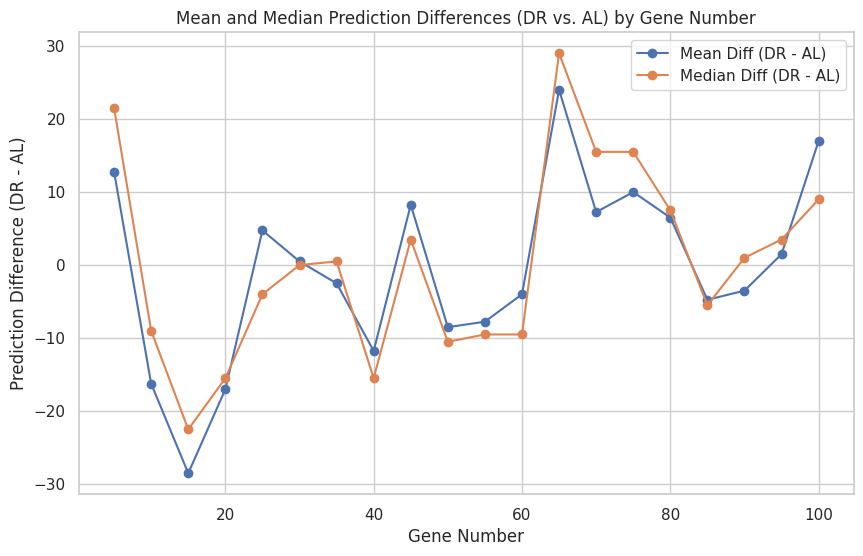

In [ ]:
# Plot mean_diff_old_young and median_diff_old_young as gene_number varies
random.seed(42)
plt.figure(figsize=(10, 6))

# Plot the mean difference
plt.plot(summary_df['gene_number'], summary_df['mean_diff_DR_AL'], label='Mean Diff (DR - AL)', marker='o')

# Plot the median difference
plt.plot(summary_df['gene_number'], summary_df['median_diff_DR_AL'], label='Median Diff (DR - AL)', marker='o')

# Add labels and title
plt.xlabel('Gene Number')
plt.ylabel('Prediction Difference (DR - AL)')
plt.title('Mean and Median Prediction Differences (DR vs. AL) by Gene Number')
plt.legend()
plt.grid(True)

plt.savefig("".join(["./plots/ExtDataFig8b_liver_female_McKay_male_DR-vs-AL_deltaAge_5-100genes.svg"]), dpi=300, bbox_inches="tight")

plt.show()


In [ ]:
df = all_predictions_df.copy()

import pandas as pd
from scipy.stats import ks_2samp, mannwhitneyu


# Function to calculate percentage overlap
def percentage_overlap(values1, values2):
    min1, max1 = min(values1), max(values1)
    min2, max2 = min(values2), max(values2)
    overlap_range = max(0, min(max1, max2) - max(min1, min2))
    total_range = max(max1, max2) - min(min1, min2)
    return overlap_range / total_range if total_range > 0 else 0

# Create a DataFrame to store results
results = []

# Iterate over unique gene numbers
for gene_number in df['gene_number'].unique():
    # Subset data for the specific gene number
    subset = df[df['gene_number'] == gene_number]
    al_values = subset[subset['feed'] == 'AL']['prediction']
    dr_values = subset[subset['feed'] == 'DR']['prediction']

    # Perform KS test
    ks_stat, ks_pvalue = ks_2samp(al_values, dr_values)

    # Perform Mann-Whitney U test
    mw_stat, mw_pvalue = mannwhitneyu(al_values, dr_values, alternative='two-sided')

    # Calculate Percentage Overlap
    overlap = percentage_overlap(al_values, dr_values)

    # Append results
    results.append({
        'gene_number': gene_number,
        'ks_stat': ks_stat,
        'ks_pvalue': ks_pvalue,
        'mw_stat': mw_stat,
        'mw_pvalue': mw_pvalue,
        'percentage_overlap': overlap
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display or save results
print(results_df)

    gene_number  ks_stat  ks_pvalue  mw_stat  mw_pvalue  percentage_overlap
0             5     0.75   0.228571      4.0   0.342857            0.727273
1            10     0.50   0.771429      9.0   0.885714            0.380435
2            15     0.50   0.771429     10.0   0.663117            0.295918
3            20     0.25   1.000000     10.0   0.685714            0.622449
4            25     0.25   1.000000      8.0   1.000000            0.639175
5            30     0.25   1.000000      8.5   1.000000            0.859649
6            35     0.50   0.771429      9.0   0.885714            0.700000
7            40     0.25   1.000000     10.0   0.685714            0.750000
8            45     0.25   1.000000      7.0   0.885714            0.628866
9            50     0.50   0.771429      7.5   1.000000            0.705128
10           55     0.50   0.771429      7.0   0.885714            0.714286
11           60     0.50   0.771429      7.0   0.885714            0.887097
12          

##### ExtDataFig8d

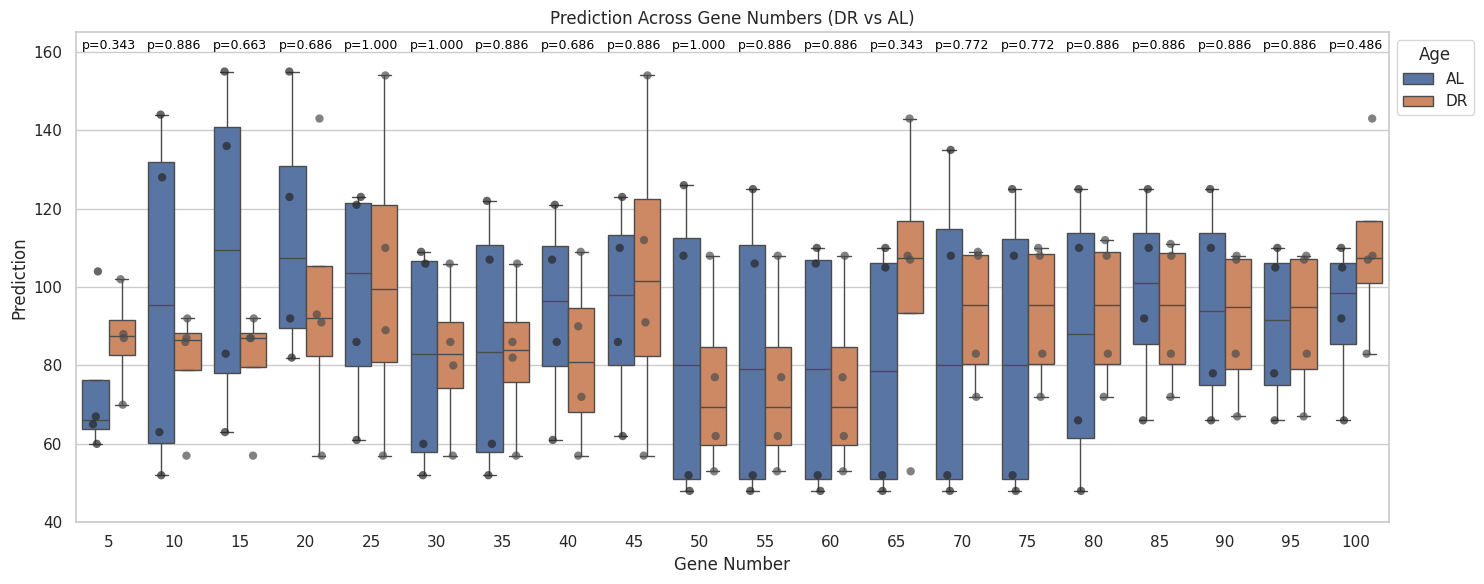

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

min_value = 40
max_value = 165

random.seed(42)

# Create the plot
plt.figure(figsize=(15, 6))
sns.set(style="whitegrid")

# Create a boxplot with paired 6.5weeks and 15weeks comparisons for each gene_number
sns.boxplot(
    data=df,
    x="gene_number",
    y="prediction",
    hue="feed",
    palette=hex_codes[0:2],
    showfliers=False
)

# Add individual points for each sample with the same age order
sns.stripplot(
    data=df,
    x="gene_number",
    y="prediction",
    hue="feed",
    dodge=True,
    palette="dark:.3",
    size=6,
    jitter=True,
    alpha=0.7
)

# Add p-values as annotations for each gene_number
gene_numbers = results_df["gene_number"].unique()
for i in range(len(gene_numbers)):
    gene_number = gene_numbers[i]
    mw_pvalue = results_df.loc[results_df["gene_number"] == gene_number, "mw_pvalue"].values[0]
    x_position = i   # Adjust to match the x-axis position of the boxplot
    plt.text(x=x_position, y=df["prediction"].max() + 5,  # Position slightly above the max prediction
             s=f"p={mw_pvalue:.3f}",
             ha="center", va="bottom", fontsize=9, color="black", rotation=0)

# Adjust the legend to remove duplicates
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title="Age", loc="upper left", bbox_to_anchor=(1, 1))

# Add titles and labels
plt.title("Prediction Across Gene Numbers (DR vs AL)")
plt.xlabel("Gene Number")
plt.ylabel("Prediction")
plt.ylim(min_value, max_value)

# Show the plot
plt.tight_layout()

# Save the plot
plt.savefig("./plots/ExtDataFig8d_liver_female_McKay_DR-vs-AL_boxplot_5-100genes.svg", dpi=300, bbox_inches="tight")

plt.show()


In [ ]:
max_gene_number = 100

# Load and prepare reference data
reference_df = pd.read_csv(f"./references/killifish_liver_reference_female", sep="\t", index_col=0)
top_abs_spearman_corr = reference_df["spearman_rank"].abs().nlargest(max_gene_number)
top_genes = top_abs_spearman_corr.index.tolist()
print(top_genes)

['LOC107377204', 'LOC107383282', 'LOC107387906', 'nptx1', 'LOC107387904', 'ldlrad4', 'LOC107376533', 'ogdh', 'LOC107390459', 'LOC107390728', 'hsd17b3', 'LOC107394435', 'LOC107388195', 'prkar1b', 'clstn2', 'LOC107373279', 'cpq', 'LOC107388379', 'kdm5b', 'LOC107379226', 'maob', 'LOC107386477', 'LOC107384947', 'pkd1l1', 'LOC107392368', 'dnajb13', 'mast3', 'minos1', 'naaladl2', 'LOC107381877', 'ptk2b', 'gab3', 'LOC107372680', 'LOC107375122', 'LOC107383960', 'pmp22', 'LOC107376652', 'slc7a10', 'snx2', 'LOC107392805', 'LOC107386936', 'dhrs11', 'LOC107377493', 'LOC107374804', 'skil', 'dio2', 'LOC107394379', 'tmem86b', 'abhd6', 'wnt10b', 'LOC107382703', 'LOC107387676', 'LOC107377339', 'LOC107386308', 'LOC107393052', 'abca3', 'ptpn6', 'adm2', 'slc38a2', 'LOC107393850', 'LOC107373093', 'LOC107384135', 'LOC107388499', 'mapk15', 'LOC107396830', 'acss3', 'LOC107376973', 'LOC107373957', 'LOC107390727', 'LOC107391237', 'LOC107388181', 'drc3', 'LOC107375933', 'dnajc10', 'LOC107380586', 'LOC107372551',

### Difference between Means

In [ ]:

mean_AL = liver_female_age_predictions_CR[liver_female_age_predictions_CR['treatment'] == 'AL']['prediction'].mean()
mean_DR = liver_female_age_predictions_CR[liver_female_age_predictions_CR['treatment'] == 'DR']['prediction'].mean()

# Calculate the differences btwn means (meanDR - meanAL)
mean_difference = mean_AL - mean_DR

mean_difference

17.0

### Difference between Medians

In [ ]:
# Separate predictions by treatment

median_AL = liver_female_age_predictions_CR[liver_female_age_predictions_CR['treatment'] == 'AL']['prediction'].median()
median_DR = liver_female_age_predictions_CR[liver_female_age_predictions_CR['treatment'] == 'DR']['prediction'].median()

# Calculate the differences btwn means (meanDR - meanAL)
median_difference = median_AL - median_DR

median_difference

15.5

### Pvalue - Mann Whitney

In [ ]:
# Assuming your DataFrame is `liver_female_age_predictions_CR`
# Replace 'prediction' and 'treatment' with the exact column names in your DataFrame

# Filter and convert 'prediction' values to numeric, forcing non-numeric to NaN
AL_values = pd.to_numeric(
    liver_female_age_predictions_CR[liver_female_age_predictions_CR['treatment'] == 'AL']['prediction'],
    errors='coerce'
)
DR_values = pd.to_numeric(
    liver_female_age_predictions_CR[liver_female_age_predictions_CR['treatment'] == 'DR']['prediction'],
    errors='coerce'
)

# Drop NaN values from each group
AL_values = AL_values.dropna()
DR_values = DR_values.dropna()

# Perform Mann-Whitney U test if both groups are non-empty
if not AL_values.empty and not DR_values.empty:
    stat, p_value = mannwhitneyu(AL_values, DR_values, alternative='two-sided')
    print("Mann-Whitney U test results:")
    print(f"Statistic: {stat}, p-value: {p_value}")
else:
    print("One or both groups are empty after filtering NaN values.")


Mann-Whitney U test results:
Statistic: 10.0, p-value: 0.6857142857142857
